### План работы
* [Подключение библиотек и скриптов](#intro)
* [Путь к директориям и файлам](#path)
* [Загрузка данных](#load)
* [Приведение типов данных (для тренировочного датасета)](#type_train)
* [Приведение типов данных (для тестового датасета)](#type_test)
* [Обзор переменных](#variables)
* [Обработка выбросов (для тренировочного датасета)](#outliers_train)
* [Обработка пропусков (для тренировочного датасета)](#missing_train)
* [Обработка выбросов и пропусков (для тестового датасета)](#outliers_test)
* [Матрица корреляций](#correlation_matrix)
* [Добавление новых признаков (для тренировочного датасета)](#new_variables)
* [Добавление новых признаков (для тестового датасета)](#new_variables_test)
* [Применение функции для уменьшения объема памяти, который занимает датасет](#memory)
* [Отбор признаков](#columns)
* [Разбиение на test и train](#train_test)
* [Построение модели](#model)
* [Построение прогноза](#forecast)
* [Сохранение результатов](#save)

### Подключение библиотек и скриптов <a class='anchor' id='intro'>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import StratifiedKFold


%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings('ignore')

Функция для уменьшения объема памяти, который занимает датасет

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Пути к директориям и файлам <a class='anchor' id='path'>

In [3]:
train_path = './train.csv'
test_path = './test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
train_df = pd.read_csv(train_path, sep=',')
test_df = pd.read_csv(test_path, sep=',')

In [5]:
train_df.head(10)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   
5  12915          59    3.0  80.384479   46.683720           12.0      5   
6  14549         154    2.0  62.254114   37.160377            7.0      3   
7  11993          74    2.0  80.312926         NaN            0.0     14   
8   5172           1    2.0  64.511437         NaN            1.0      9   
9   8649          23    1.0  46.461409   18.915552            8.0     13   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   
5        17.0       2011   0.309479         B         B        35      7715   
6         5.0       1960   0.460556         B         B        20      4386   
7         0.0       1977   0.075779         B         B         6      1437   
8        17.0       1977   0.007122         B         B         1       264   
9        17.0       2014   0.075779         B         B         6      1437   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644  
5         4         990.0            0        6       B  215898.447742  
6        14           NaN            1        5       B  296021.204377  
7         3           NaN            0        2       B  221244.156664  
8         0           NaN            0        1       B  229102.795999  
9         3           NaN            0        2       B   95380.220993

In [6]:
test_df.head(10)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725          58    2.0  49.882643   33.432782            6.0      6   
1  15856          74    2.0  69.263183         NaN            1.0      6   
2   5480         190    1.0  13.597819   15.948246           12.0      2   
3  15664          47    2.0  73.046609   51.940842            9.0     22   
4  14275          27    1.0  47.527111   43.387569            1.0     17   
5   7633          53    1.0  40.675627         NaN            1.0     21   
6  13329          23    2.0  68.099538   64.843025            1.0      2   
7   5502          32    2.0  48.193897   32.857644            6.0      5   
8   4220          96    3.0  72.277106   45.968758            9.0     17   
9  11538           6    3.0  80.219400   47.660260            9.0     13   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        14.0       1972   0.310199         B         B        11      2748   
1         1.0       1977   0.075779         B         B         6      1437   
2         5.0       1909   0.000000         B         B        30      7538   
3        22.0       2007   0.101872         B         B        23      4583   
4        17.0       2017   0.072158         B         B         2       629   
5        21.0       1977   0.049637         B         B        34      7759   
6        17.0       1977   0.075779         B         B         6      1437   
7        14.0       1972   0.135650         B         B        46      7960   
8        17.0       1997   0.041116         B         B        53     14892   
9        17.0       2014   0.243205         B         B         5      1564   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         1           NaN            0        0       B  
1         3           NaN            0        2       B  
2        87        4702.0            5        5       B  
3         3           NaN            3        3       B  
4         1           NaN            0        0       A  
5         0         229.0            1        3       B  
6         3           NaN            0        2       B  
7         6         350.0            3       11       B  
8         4           NaN            1        4       B  
9         0         540.0            0        0       B

### Приведение типов данных (для тренировочного датасета) <a class='anchor' id='type_train'>

In [7]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [8]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

Преобразование колонки Id к типу строка

In [9]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['Id'].dtype

dtype('O')

Приведение признака "DistrictId" к строке

In [10]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['DistrictId'].dtype

dtype('O')

### Приведение типов данных (для тестового датасета) <a class='anchor' id='type_test'>

In [11]:
test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [12]:
test_df.dtypes.value_counts()

int64      9
float64    7
object     3
dtype: int64

Преобразование колонки Id в индекс и колонки DistrictId к типу str

In [13]:
test_df.head(10)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725          58    2.0  49.882643   33.432782            6.0      6   
1  15856          74    2.0  69.263183         NaN            1.0      6   
2   5480         190    1.0  13.597819   15.948246           12.0      2   
3  15664          47    2.0  73.046609   51.940842            9.0     22   
4  14275          27    1.0  47.527111   43.387569            1.0     17   
5   7633          53    1.0  40.675627         NaN            1.0     21   
6  13329          23    2.0  68.099538   64.843025            1.0      2   
7   5502          32    2.0  48.193897   32.857644            6.0      5   
8   4220          96    3.0  72.277106   45.968758            9.0     17   
9  11538           6    3.0  80.219400   47.660260            9.0     13   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        14.0       1972   0.310199         B         B        11      2748   
1         1.0       1977   0.075779         B         B         6      1437   
2         5.0       1909   0.000000         B         B        30      7538   
3        22.0       2007   0.101872         B         B        23      4583   
4        17.0       2017   0.072158         B         B         2       629   
5        21.0       1977   0.049637         B         B        34      7759   
6        17.0       1977   0.075779         B         B         6      1437   
7        14.0       1972   0.135650         B         B        46      7960   
8        17.0       1997   0.041116         B         B        53     14892   
9        17.0       2014   0.243205         B         B         5      1564   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         1           NaN            0        0       B  
1         3           NaN            0        2       B  
2        87        4702.0            5        5       B  
3         3           NaN            3        3       B  
4         1           NaN            0        0       A  
5         0         229.0            1        3       B  
6         3           NaN            0        2       B  
7         6         350.0            3       11       B  
8         4           NaN            1        4       B  
9         0         540.0            0        0       B

In [14]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['Id'].dtype
test_df['DistrictId'] = test_df['DistrictId'].astype(str)
test_df['DistrictId'].dtype

dtype('O')

### Обзор переменных <a class='anchor' id='variables'>

***Обзор количественных переменных***

In [15]:
train_df.dtypes.value_counts()

float64    8
int64      7
object     5
dtype: int64

In [16]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features.head(10)

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
0    2.0  47.981561   29.442751            6.0      7         9.0       1969   
1    3.0  65.683640   40.049543            8.0      7         9.0       1978   
2    2.0  44.947953   29.197612            0.0      8        12.0       1968   
3    2.0  53.352981   52.731512            9.0      8        17.0       1977   
4    1.0  39.649192   23.776169            7.0     11        12.0       1976   
5    3.0  80.384479   46.683720           12.0      5        17.0       2011   
6    2.0  62.254114   37.160377            7.0      3         5.0       1960   
7    2.0  80.312926         NaN            0.0     14         0.0       1977   
8    2.0  64.511437         NaN            1.0      9        17.0       1977   
9    1.0  46.461409   18.915552            8.0     13        17.0       2014   

   Ecology_1  Social_1  Social_2  Social_3  Healthcare_1  Helthcare_2  \
0   0.089040        33      7976         5           NaN            0   
1   0.000070        46     10309         1         240.0            1   
2   0.049637        34      7759         0         229.0            1   
3   0.437885        23      5735         3        1084.0            0   
4   0.012339        35      5776         1        2078.0            2   
5   0.309479        35      7715         4         990.0            0   
6   0.460556        20      4386        14           NaN            1   
7   0.075779         6      1437         3           NaN            0   
8   0.007122         1       264         0           NaN            0   
9   0.075779         6      1437         3           NaN            0   

   Shops_1          Price  
0       11  184966.930730  
1       16  300009.450063  
2        3  220925.908524  
3        5  175616.227217  
4        4  150226.531644  
5        6  215898.447742  
6        5  296021.204377  
7        2  221244.156664  
8        1  229102.795999  
9        2   95380.220993

In [17]:
df_num_features.drop('Price', axis=1, inplace=True)

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

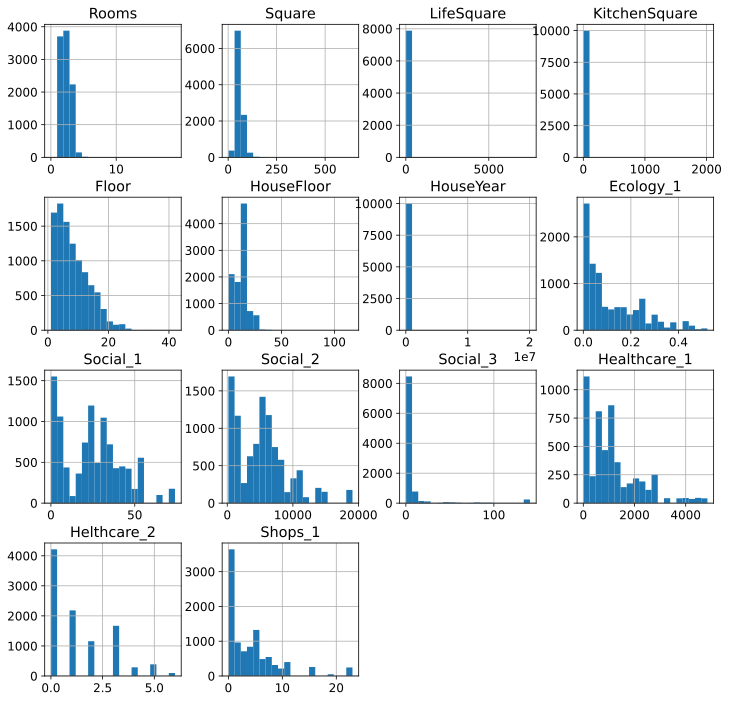

In [18]:
df_num_features.hist(figsize=(12,12), bins=20, grid=True)

In [19]:
train_df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.890500     56.315775    37.199645       6.273300      8.526700   
std        0.839512     21.058732    86.241209      28.560917      5.241148   
min        0.000000      1.136859     0.370619       0.000000      1.000000   
25%        1.000000     41.774881    22.769832       1.000000      4.000000   
50%        2.000000     52.513310    32.781260       6.000000      7.000000   
75%        2.000000     65.900625    45.128803       9.000000     12.000000   
max       19.000000    641.065193  7480.592129    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904460      1.319500      4.231300  214138.857399  
std       23.831875   1021.517264      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    350.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        5.000000   1548.000000      2.000000      6.000000  249135.462171  
max      141.000000   4849.000000      6.000000     23.000000  633233.466570

***Обзор категориальных переменных***

In [20]:
df_obj_features = train_df.select_dtypes(include='object')
df_obj_features.head(10)

Id DistrictId Ecology_2 Ecology_3 Shops_2
0  14038         35         B         B       B
1  15053         41         B         B       B
2   4765         53         B         B       B
3   5809         58         B         B       B
4  10783         99         B         B       B
5  12915         59         B         B       B
6  14549        154         B         B       B
7  11993         74         B         B       B
8   5172          1         B         B       B
9   8649         23         B         B       B

In [21]:
train_df['DistrictId'].value_counts().sort_values(ascending=False).head(10)

27    851
1     652
23    565
6     511
9     294
62    247
30    228
58    179
53    174
21    165
Name: DistrictId, dtype: int64

In [22]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [23]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [24]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов (для тренировочного датасета) <a class='anchor' id='outliers_train'>

In [25]:
train_df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.890500     56.315775    37.199645       6.273300      8.526700   
std        0.839512     21.058732    86.241209      28.560917      5.241148   
min        0.000000      1.136859     0.370619       0.000000      1.000000   
25%        1.000000     41.774881    22.769832       1.000000      4.000000   
50%        2.000000     52.513310    32.781260       6.000000      7.000000   
75%        2.000000     65.900625    45.128803       9.000000     12.000000   
max       19.000000    641.065193  7480.592129    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904460      1.319500      4.231300  214138.857399  
std       23.831875   1021.517264      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    350.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        5.000000   1548.000000      2.000000      6.000000  249135.462171  
max      141.000000   4849.000000      6.000000     23.000000  633233.466570

Вначале рассмотрим наличие выбросов в ценах на недвижимость (в таргетной переменной)

In [26]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]
target_mean, target_median, target_mode

(214138.86, 192269.64487934904, 59174.77802758122)

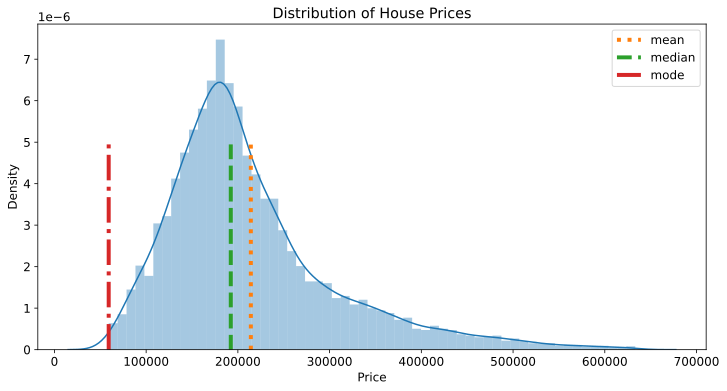

In [27]:
plt.figure(figsize = (12, 6))

sns.distplot(train_df['Price'], bins=59) 

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of House Prices')
plt.legend()
plt.show()

***Rooms***

В графике выше (при рассмотрении количественных признаков) видно, что возможно есть выбросы в признаке Rooms)

Рассмотрим подробнее

In [28]:
train_df['Rooms'].value_counts().sort_index()

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

Заменим значения, равные 0, 6, 10 и 19 на медиану

In [29]:
train_df.loc[train_df['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts().sort_index()

1.0    3705
2.0    3892
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

***Square**

В графиках выше (при рассмотрении количественных признаков) видно, что есть выбросы в признаках Square, LifeSquare, KitchenSquare)

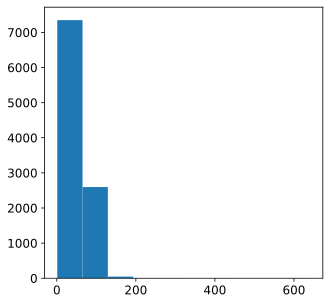

In [30]:
train_df.loc[:, 'Square'].\
    hist(figsize=(5,5), bins=10, grid=False);

In [31]:
train_df[train_df['Square'] >= 300]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
4262     28          9    2.0  604.705972         NaN            1.0     17   
4690   2307        102    1.0  409.425181  410.639749           10.0      4   
6977  11602         30    2.0  641.065193  638.163193           10.0     20   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4262        18.0       1977   0.161532         B         B        25   
4690         4.0       2016   0.238617         B         B        26   
6977        19.0       2019   0.000078         B         B        22   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
4262      5648         1          30.0            2        4       B   
4690      3889         6         705.0            3        6       B   
6977      6398       141        1046.0            3       23       B   

              Price  
4262  187717.242538  
4690   90470.430830  
6977  133529.681562

Заменим значения площади больше 300 на медианное значение группы (в заисимости от того, сколько комнат в той или иной квартире)

In [32]:
train_df.loc[train_df['Square'] >= 300 , 'Square'] = None
train_df['Square'].fillna(train_df.groupby('Rooms')['Square'].transform('median'), inplace=True)
train_df[train_df['Square'] >= 300].shape

(0, 20)

Также проверим значения площади меньше 15

In [33]:
train_df[train_df['Square'] <= 15]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
212    1748         88    2.0   5.497061   67.628717            1.0     24   
1316  11526         27    1.0   4.633498    1.969969            1.0     18   
1608  10202          6    1.0   2.596351    4.604943            1.0      3   
3280  10527         27    1.0   4.380726   40.805837            1.0     10   
3413   9487          5    1.0   5.129222    5.549458            1.0      1   
4739  12676         81    3.0  13.784865   15.988889            7.0      4   
4853   3224         27    2.0   2.377248    0.873147            0.0      1   
4900   4504         27    3.0   4.390331    5.610772            1.0      8   
6392  14786          1    1.0   1.136859    4.525736            1.0      3   
8030  13265          1    3.0   4.823679   79.767964            0.0      6   
8283  15744         34    1.0   1.988943    2.642219            1.0     21   
9294   6782         45    1.0   2.954309    5.257278            1.0      3   
9613   7657         38    1.0   4.502784    4.618547            1.0     28   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
212         22.0       1977   0.127376         B         B        43   
1316         1.0       1977   0.011654         B         B         4   
1608        25.0       2014   0.243205         B         B         5   
3280        17.0       2013   0.211401         B         B         9   
3413         1.0       1977   0.150818         B         B        16   
4739         5.0       1960   0.319809         B         B        25   
4853         0.0       1977   0.017647         B         B         2   
4900        19.0       2016   0.211401         B         B         9   
6392         1.0       1977   0.007122         B         B         1   
8030        17.0       1977   0.007122         B         B         1   
8283         4.0       1977   0.069753         B         B        53   
9294         1.0       1977   0.195781         B         B        23   
9613         1.0       1977   0.060753         B         B        15   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
212       8429         3           NaN            3        9       B   
1316       915         0           NaN            0        0       B   
1608      1564         0         540.0            0        0       B   
3280      1892         0           NaN            0        1       B   
3413      3433         4        2643.0            4        5       B   
4739      4756        16        2857.0            5        8       B   
4853       469         0           NaN            0        0       B   
4900      1892         0           NaN            0        1       B   
6392       264         0           NaN            0        1       B   
8030       264         0           NaN            0        1       B   
8283     13670         4           NaN            1       11       B   
9294      5212         6           NaN            3        2       B   
9613      2787         2         520.0            0        7       B   

              Price  
212   412511.088764  
1316  107604.269441  
1608  137597.601458  
3280   97560.720383  
3413  369472.403061  
4739   78388.806186  
4853  126596.941798  
4900  161379.067034  
6392  181434.825589  
8030  237716.681261  
8283  458378.777006  
9294  438005.182323  
9613  483283.488083

Заменим значения площади меньше 15 на медианное значение группы (в заисимости от того, сколько комнат в той или иной квартире)

In [34]:
train_df.loc[train_df['Square'] <= 15 , 'Square'] = None
train_df['Square'].fillna(train_df.groupby('Rooms')['Square'].transform('median'), inplace=True)
train_df[train_df['Square'] <= 15].shape

(0, 20)

***KitchenSquare***

Теперь проверим на наличие выбросов в признаке KitchenSquare

In [35]:
train_df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.888400     56.226374    37.199645       6.273300      8.526700   
std        0.811056     19.067658    86.241209      28.560917      5.241148   
min        1.000000     16.117154     0.370619       0.000000      1.000000   
25%        1.000000     41.783182    22.769832       1.000000      4.000000   
50%        2.000000     52.537977    32.781260       6.000000      7.000000   
75%        2.000000     65.900625    45.128803       9.000000     12.000000   
max        5.000000    275.645284  7480.592129    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904460      1.319500      4.231300  214138.857399  
std       23.831875   1021.517264      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    350.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        5.000000   1548.000000      2.000000      6.000000  249135.462171  
max      141.000000   4849.000000      6.000000     23.000000  633233.466570

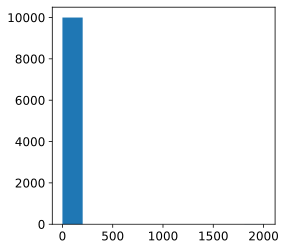

In [36]:
train_df.loc[:, 'KitchenSquare'].\
    hist(figsize=(4,4), bins=10, grid=False);

In [37]:
train_df[train_df['KitchenSquare'] > train_df['Square']]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1064  14656         62    1.0  47.100719   46.447960         2014.0      4   
5149  13703         42    1.0  38.071692   19.723548           73.0      9   
7088   6569         27    1.0  38.220258   18.716856           84.0      4   
8584  14679         81    1.0  32.276663   19.278394         1970.0      6   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1064         1.0       2014   0.072158         B         B         2   
5149        10.0       2006   0.158249         B         B        21   
7088        17.0       2018   0.011654         B         B         4   
8584         1.0       1977   0.006076         B         B        30   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1064       629         1           NaN            0        0       A   
5149      5731         0           NaN            1        0       B   
7088       915         0           NaN            0        0       B   
8584      5285         0         645.0            6        6       B   

              Price  
1064  108337.484207  
5149  160488.033165  
7088   99079.960518  
8584  105539.556275

Заменим такие значения на разность между Square и LifeSqaure

In [38]:
train_df.loc[(train_df['KitchenSquare'] > train_df['Square']), 'KitchenSquare'] = \
                          train_df.loc[(train_df['KitchenSquare'] > train_df['Square']), 'Square'] - \
                          train_df.loc[(train_df['KitchenSquare'] > train_df['Square']), 'LifeSquare']
train_df[(train_df['KitchenSquare'] > train_df['Square'])].shape

(0, 20)

Теперь рассмотрим такие случаи, когда отношение кухонной площади от общей площади составляет более 70%

In [39]:
train_df[(train_df['KitchenSquare'] / train_df['Square'] >= 0.7)].head(10)

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
227   16395          2    3.0   79.722243   44.731219           72.0     12   
551    1315          6    1.0   48.128114   45.023531           48.0     21   
1077   9690         27    1.0   40.081042   37.834964           37.0     18   
1369   2371         27    2.0   68.841073   64.234956           66.0      4   
1455  12507         54    2.0   79.810535   79.578961           78.0     10   
1860   4265        161    2.0   53.216778   32.644859           53.0      7   
2916  12390         72    3.0   97.490674   99.323558           96.0     22   
2969   7441         62    3.0  114.734473  112.589083          112.0      3   
3379  16781         27    1.0   36.138409   36.710539           36.0     19   
4079   6508         23    2.0   67.146049   33.959154           63.0      5   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
227         16.0       1987   0.130618         B         B        39   
551          1.0       2013   0.243205         B         B         5   
1077        19.0       2019   0.211401         B         B         9   
1369         2.0       2014   0.017647         B         B         2   
1455        15.0       2014   0.006076         B         B        30   
1860        17.0       1994   0.000699         B         B        14   
2916        25.0       2019   0.210473         B         B        11   
2969         3.0       2015   0.072158         B         B         2   
3379        19.0       2017   0.072158         B         B         2   
4079        17.0       2019   0.034656         B         B         0   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
227      10418         9         900.0            1        9       B   
551       1564         0         540.0            0        0       B   
1077      1892         0           NaN            0        1       B   
1369       469         0           NaN            0        0       B   
1455      5285         0         645.0            6        6       B   
1860      3369        24        4129.0            0        3       B   
2916      2398         2        1994.0            3        0       B   
2969       629         1           NaN            0        0       A   
3379       629         1           NaN            0        0       A   
4079       168         0           NaN            0        0       B   

              Price  
227   370148.625285  
551   146950.912410  
1077   93218.650461  
1369  189244.249909  
1455  438708.707579  
1860  261125.669724  
2916  445074.956552  
2969  315245.521059  
3379  131742.536281  
4079  193130.585871

Заменим такие случаи на медианное отношение между кухонной площадью и общей площадью по всей выборке

In [40]:
train_df.loc[(train_df['KitchenSquare'] / train_df['Square']) >= 0.7, 'KitchenSquare'] = None
median_value = (train_df['KitchenSquare'] / train_df['Square']).dropna().median()
median_value

0.12022140693365155

In [41]:
train_df.loc[train_df['KitchenSquare'].isnull(), 'KitchenSquare']= \
                  median_value * \
                  train_df.loc[train_df['KitchenSquare'].isnull(), 'Square']
train_df[(train_df['KitchenSquare'] / train_df['Square'] >= 0.7)].shape

(0, 20)

Рассмотрим случаи, когда площадь кухни меньше 4

In [42]:
train_df.loc[train_df['KitchenSquare'] < 4 , :].head(10)

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
2    4765         53    2.0   44.947953   29.197612            0.0      8   
7   11993         74    2.0   80.312926         NaN            0.0     14   
8    5172          1    2.0   64.511437         NaN            1.0      9   
12   6452         13    2.0   54.522805   31.759753            1.0      8   
14  10953         27    1.0   53.769097   52.408027            1.0      5   
21  11935         27    2.0   64.711835         NaN            1.0     15   
23   6641         54    3.0  118.907612         NaN            0.0      2   
25   5073         74    2.0   82.667915         NaN            1.0     16   
26   4378         27    3.0  106.958871    0.641822            0.0     17   
27   7550         23    2.0   64.556209         NaN            1.0      8   

    HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
2         12.0       1968   0.049637         B         B        34      7759   
7          0.0       1977   0.075779         B         B         6      1437   
8         17.0       1977   0.007122         B         B         1       264   
12        12.0       1999   0.090799         B         B        74     19083   
14         4.0       1977   0.072158         B         B         2       629   
21         1.0       1977   0.211401         B         B         9      1892   
23         0.0       1977   0.006076         B         B        30      5285   
25        17.0       1977   0.075779         B         B         6      1437   
26         0.0       2018   0.072158         B         B         2       629   
27        17.0       1977   0.075779         B         B         6      1437   

    Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
2          0         229.0            1        3       B  220925.908524  
7          3           NaN            0        2       B  221244.156664  
8          0           NaN            0        1       B  229102.795999  
12         2           NaN            5       15       B  229220.372609  
14         1           NaN            0        0       A  140647.565937  
21         0           NaN            0        1       B  127200.026511  
23         0         645.0            6        6       B  571069.052600  
25         3           NaN            0        2       B  244145.827069  
26         1           NaN            0        0       A  337299.867936  
27         3           NaN            0        2       B  173910.923723

Также заменим такие случаи на медианное отношение между кухонной площадью и общей площадью по всей выборке

In [43]:
train_df.loc[train_df['KitchenSquare'] < 4 , 'KitchenSquare'] = None
train_df.loc[train_df['KitchenSquare'].isnull() , 'KitchenSquare'] = ((train_df['KitchenSquare'].dropna() / train_df['Square']).median() * \
                                train_df.loc[train_df['KitchenSquare'].isnull() , 'Square']) 

In [44]:
train_df.loc[train_df['KitchenSquare'] < 4 , 'KitchenSquare'].head(10)

501     3.925067
900     3.963264
1476    3.486049
1891    2.586618
3084    2.987886
3794    2.736009
4118    3.093103
4364    3.354242
4650    3.658483
4721    3.652860
Name: KitchenSquare, dtype: float64

Оставшиеся случаи заменим на 4

In [45]:
train_df.loc[train_df['KitchenSquare'] < 4 , 'KitchenSquare'] = 4
train_df.loc[train_df['KitchenSquare'] < 4 , 'KitchenSquare'].shape

(0,)

***LifeSquare***

Теперь рассмотрим переменную LifeSquare

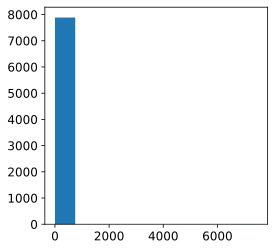

In [46]:
train_df.loc[:, 'LifeSquare'].\
    hist(figsize=(4,4), bins=10, grid=False);

Рассмотрим случаи, когда сумма площадей LifeSquare и KitchenSquare больше общей площади недвижимости

In [47]:
train_df[train_df['LifeSquare'] + train_df['KitchenSquare'] > train_df['Square']].head(10)

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
3    5809         58    2.0   53.352981   52.731512       9.000000      8   
14  10953         27    1.0   53.769097   52.408027       7.948097      5   
28   8054         23    1.0   42.530043   43.967759       6.286751      3   
42   9833          1    2.0   56.494318   54.723569       8.350937      9   
44  10521         38    3.0  104.211396  106.340403      15.404431     20   
48   7596         23    1.0   47.080100   46.807989      12.000000      3   
52   2301          1    2.0   61.400054   65.224603       9.076098     17   
69   6925         27    2.0   64.929103   63.304605      10.000000     15   
71   2136         74    2.0   84.687732   81.905552      12.518461     12   
72  14675         74    1.0   52.457589   52.423345       7.754232     18   

    HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
3         17.0       1977   0.437885         B         B        23      5735   
14         4.0       1977   0.072158         B         B         2       629   
28         9.0       2014   0.034656         B         B         0       168   
42        17.0       1977   0.007122         B         B         1       264   
44         0.0       2017   0.060753         B         B        15      2787   
48         9.0       1977   0.014073         B         B         2       475   
52        22.0       2016   0.007122         B         B         1       264   
69        17.0       2016   0.072158         B         B         2       629   
71        17.0       2017   0.075779         B         B         6      1437   
72        17.0       1977   0.075779         B         B         6      1437   

    Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
3          3        1084.0            0        5       B  175616.227217  
14         1           NaN            0        0       A  140647.565937  
28         0           NaN            0        0       B   95338.198549  
42         0           NaN            0        1       B  196078.907289  
44         2         520.0            0        7       B  435462.048070  
48         0           NaN            0        0       B   96029.167877  
52         0           NaN            0        1       B  199215.452229  
69         1           NaN            0        0       A  228584.001072  
71         3           NaN            0        2       B  243479.876105  
72         3           NaN            0        2       B  160292.163702

Заменим такие случаи на разность между общей площадью и площадью кухни

In [48]:
train_df.loc[(train_df['LifeSquare'] + train_df['KitchenSquare'] > train_df['Square']),'LifeSquare'] = \
           train_df.loc[(train_df['LifeSquare'] + train_df['KitchenSquare'] > train_df['Square']),'Square'] - \
           train_df.loc[(train_df['LifeSquare'] + train_df['KitchenSquare'] > train_df['Square']),'KitchenSquare']

Рассмотрим случаи, когда отношение суммы жилой и кухонной площадей от общей площади квартиры меньше 50%

In [49]:
train_df[((train_df['LifeSquare'] + train_df['KitchenSquare']) / train_df['Square']) < 0.5].head(10)

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
26    4378         27    3.0  106.958871    0.641822      15.810560     17   
95    4280         34    2.0   61.334968    4.091945       9.066477     26   
134  12613          6    2.0   65.496674    5.589324       9.681657      5   
158  16779         27    3.0   51.991064    4.896202       7.685270     22   
160   3522          6    1.0   66.419841    3.987101       9.818119      2   
270  15215         17    1.0   46.692974    5.941401       6.902112      7   
279   8727          1    2.0   79.521221    4.634049      11.754752      5   
363  15751          9    1.0   44.171793    1.251846       6.529433     11   
475   6333         27    2.0   64.049695    4.008230       9.467766      5   
477   8849         45    1.0   63.419553    2.286357       9.374619      3   

     HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
26          0.0       2018   0.072158         B         B         2       629   
95          1.0       2014   0.069753         B         B        53     13670   
134        17.0       1977   0.243205         B         B         5      1564   
158        25.0       1977   0.072158         B         B         2       629   
160         1.0       1977   0.243205         B         B         5      1564   
270         1.0       2015   0.000000         B         B        18      3374   
279         1.0       2017   0.007122         B         B         1       264   
363        18.0       2017   0.161532         B         B        25      5648   
475         5.0       2017   0.017647         B         B         2       469   
477         1.0       1977   0.195781         B         B        23      5212   

     Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
26          1           NaN            0        0       A  337299.867936  
95          4           NaN            1       11       B  286564.441972  
134         0         540.0            0        0       B  180727.643541  
158         1           NaN            0        0       A  174687.566186  
160         0         540.0            0        0       B  193361.229815  
270         5         620.0            1        2       B  212290.684086  
279         0           NaN            0        1       B  232726.628137  
363         1          30.0            2        4       B  134910.715588  
475         0           NaN            0        0       B  189477.560210  
477         6           NaN            3        2       B  325600.765809

Заменим значения LifeSquare для такой выборки на разность между общей площадью и квартирной площадью

In [50]:
train_df.loc[((train_df['LifeSquare'] + train_df['KitchenSquare']) / train_df['Square']) < 0.5, 'LifeSquare'] = \
         train_df.loc[((train_df['LifeSquare'] + train_df['KitchenSquare']) / train_df['Square']) < 0.5, 'Square'] - \
         train_df.loc[((train_df['LifeSquare'] + train_df['KitchenSquare']) / train_df['Square']) < 0.5, 'KitchenSquare']

In [51]:
train_df[((train_df['LifeSquare'] + train_df['KitchenSquare']) / train_df['Square']) < 0.5].shape

(0, 20)

In [52]:
train_df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.888400     56.226374    36.014068       8.291235      8.526700   
std        0.811056     19.067658    15.385522       2.752950      5.241148   
min        1.000000     16.117154     8.547242       4.000000      1.000000   
25%        1.000000     41.783182    23.420568       6.000000      4.000000   
50%        2.000000     52.537977    33.023569       8.000000      7.000000   
75%        2.000000     65.900625    44.988541      10.000000     12.000000   
max        5.000000    275.645284   233.949309      43.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904460      1.319500      4.231300  214138.857399  
std       23.831875   1021.517264      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    350.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        5.000000   1548.000000      2.000000      6.000000  249135.462171  
max      141.000000   4849.000000      6.000000     23.000000  633233.466570

***HouseYear***

Рассмотрим уникальные значения для данной переменной

In [53]:
train_df['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

Заменим значения больше 2020 на 2020 год

In [54]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020
train_df['HouseYear'].value_counts().sort_index()

1910      1
1912      2
1914      1
1916      1
1917      3
       ... 
2016    305
2017    308
2018    175
2019     79
2020     21
Name: HouseYear, Length: 95, dtype: int64

***Floor, Housefloor***

Рассмотрим значения, когда House floor = 0 и заменим их на медиану

In [55]:
train_df[train_df['HouseFloor'] == 0].head(10)

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
7    11993         74    2.0   80.312926         NaN      11.871781     14   
23    6641         54    3.0  118.907612         NaN      17.576811      2   
26    4378         27    3.0  106.958871   91.148311      15.810560     17   
39    9371         23    2.0   60.503248         NaN       8.943533     16   
44   10521         38    3.0  104.211396   88.806965      15.404431     20   
65   11398         62    1.0   41.194188         NaN       6.089286      6   
70   10362         27    2.0   79.227049         NaN      11.711268      9   
195   4645         54    2.0   76.312851         NaN      11.280494     14   
223   4622         27    2.0   62.153994   36.094352       9.187545      5   
252   8139         27    2.0   58.553809         NaN       8.655369      7   

     HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
7           0.0       1977   0.075779         B         B         6      1437   
23          0.0       1977   0.006076         B         B        30      5285   
26          0.0       2018   0.072158         B         B         2       629   
39          0.0       1977   0.034656         B         B         0       168   
44          0.0       2017   0.060753         B         B        15      2787   
65          0.0       1977   0.072158         B         B         2       629   
70          0.0       1977   0.072158         B         B         2       629   
195         0.0       1977   0.006076         B         B        30      5285   
223         0.0       1977   0.072158         B         B         2       629   
252         0.0       1977   0.072158         B         B         2       629   

     Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
7           3           NaN            0        2       B  221244.156664  
23          0         645.0            6        6       B  571069.052600  
26          1           NaN            0        0       A  337299.867936  
39          0           NaN            0        0       B  229778.057902  
44          2         520.0            0        7       B  435462.048070  
65          1           NaN            0        0       A  114063.092041  
70          1           NaN            0        0       A  167023.973143  
195         0         645.0            6        6       B  466730.805333  
223         1           NaN            0        0       A  194091.992560  
252         1           NaN            0        0       A  177511.314827

In [56]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()
train_df[train_df['HouseFloor'] == 0].shape

(0, 20)

Рассмотрим случаи, когда этаж квартиры выше этажности жилого дома

In [57]:
train_df[train_df['Floor'] > train_df['HouseFloor']].head(10)

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
7   11993         74    2.0   80.312926         NaN      11.871781     14   
14  10953         27    1.0   53.769097   45.821000       7.948097      5   
16   2119         27    2.0   49.360648   31.993964       5.000000      6   
21  11935         27    2.0   64.711835         NaN       9.565643     15   
26   4378         27    3.0  106.958871   91.148311      15.810560     17   
35   6486        200    3.0   85.280389   58.447967       9.000000      6   
39   9371         23    2.0   60.503248         NaN       8.943533     16   
44  10521         38    3.0  104.211396   88.806965      15.404431     20   
51  10103         94    1.0   35.280894   23.354176       6.000000     11   
67   8443         57    2.0   45.964890   29.141212       5.000000      7   

    HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
7         13.0       1977   0.075779         B         B         6      1437   
14         4.0       1977   0.072158         B         B         2       629   
16         5.0       1983   0.051815         B         B         5      1227   
21         1.0       1977   0.211401         B         B         9      1892   
26        13.0       2018   0.072158         B         B         2       629   
35         5.0       1960   0.000000         B         B        33      7425   
39        13.0       1977   0.034656         B         B         0       168   
44        13.0       2017   0.060753         B         B        15      2787   
51         9.0       1971   0.282798         B         B        33      8667   
67         5.0       1963   0.133215         B         B        49     11395   

    Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
7          3           NaN            0        2       B  221244.156664  
14         1           NaN            0        0       A  140647.565937  
16         0           NaN            0        0       B  117000.381287  
21         0           NaN            0        1       B  127200.026511  
26         1           NaN            0        0       A  337299.867936  
35         1           NaN            2        5       B  402871.916317  
39         0           NaN            0        0       B  229778.057902  
44         2         520.0            0        7       B  435462.048070  
51         2           NaN            0        6       B  148862.210174  
67         3        1406.0            3        4       A  180538.898922

Заменим такие значения Floor на этажность жилого комлпекса, в котором находится та или иная квартира

In [58]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']
train_df[train_df['Floor'] > train_df['HouseFloor']].shape

(0, 20)

***Social_3***

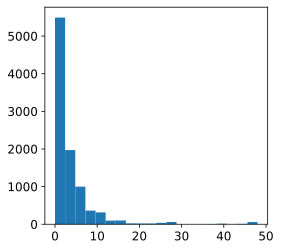

In [59]:
train_df.loc[train_df['Social_3'] < 50, 'Social_3'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [60]:
train_df.loc[train_df['Social_3'] > 15, 'Social_3'] = train_df['Social_3'].median()

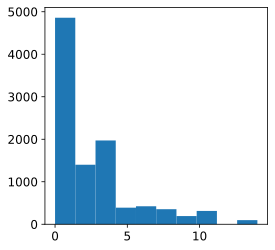

In [61]:
train_df.loc[train_df['Social_3'] < 20, 'Social_3'].\
    hist(figsize=(4,4), bins=10, grid=False);

Рассмотрим, насколько поменялась статистика после удаления выбросов

In [62]:
train_df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.888400     56.226374    36.014068       8.291235      7.918200   
std        0.811056     19.067658    15.385522       2.752950      5.186386   
min        1.000000     16.117154     8.547242       4.000000      1.000000   
25%        1.000000     41.783182    23.420568       6.000000      4.000000   
50%        2.000000     52.537977    33.023569       8.000000      7.000000   
75%        2.000000     65.900625    44.988541      10.000000     11.000000   
max        5.000000    275.645284   233.949309      43.000000     42.000000   

        HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      12.95910   1984.872400      0.118858     24.687000   5352.157400   
std        6.44346     18.416347      0.119025     17.532614   4006.799803   
min        1.00000   1910.000000      0.000000      0.000000    168.000000   
25%        9.00000   1974.000000      0.017647      6.000000   1564.000000   
50%       13.00000   1977.000000      0.075424     25.000000   5285.000000   
75%       17.00000   2001.000000      0.195781     36.000000   7227.000000   
max      117.00000   2020.000000      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       2.494800   1142.904460      1.319500      4.231300  214138.857399  
std        2.885967   1021.517264      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    350.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        4.000000   1548.000000      2.000000      6.000000  249135.462171  
max       14.000000   4849.000000      6.000000     23.000000  633233.466570

### Обработка пропусков (для тренировочного датасета) <a class='anchor' id='missing_train'>

In [63]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

***LifeSquare***

In [64]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] - \
                                                              train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare']
train_df['LifeSquare'].isnull().sum()

0

***Healthcare_1***

In [65]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()
train_df['Healthcare_1'].isnull().sum()

0

Рассмотрим, как изменилиось распредление значений признаков после обработки выбросов и пропусков

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

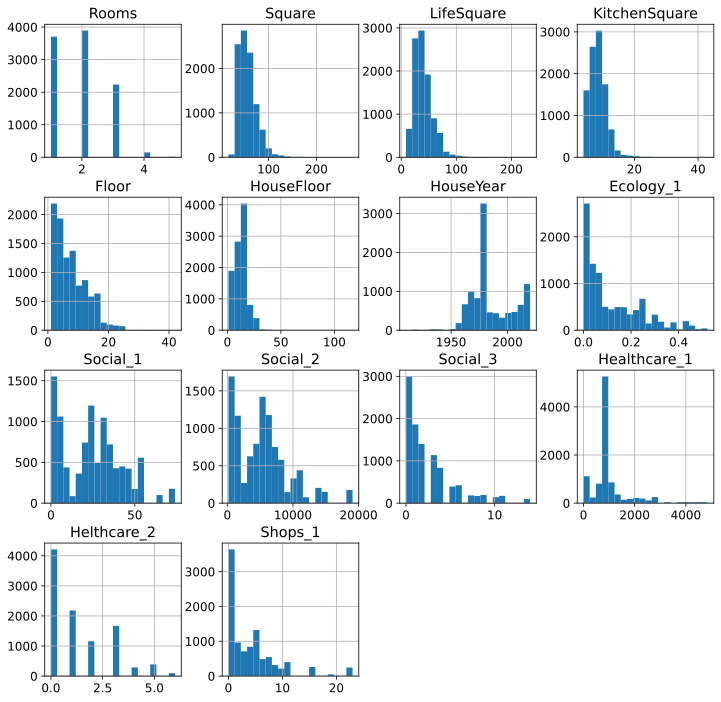

In [66]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features.drop('Price', axis=1, inplace=True)
df_num_features.hist(figsize=(12,12), bins=20, grid=True)

### Обработка выбросов и пропусков (для тестового датасета) <a class='anchor' id='outliers_test'>

#### Обработка выбросов

In [67]:
test_df.describe()

Rooms       Square   LifeSquare  KitchenSquare        Floor  \
count  5000.000000  5000.000000  3959.000000    5000.000000  5000.000000   
mean      1.910000    56.449500    36.158810       5.976800     8.632000   
std       0.838594    19.092787    17.825287       9.950018     5.483228   
min       0.000000     1.378543     0.333490       0.000000     1.000000   
25%       1.000000    41.906231    23.092026       1.000000     4.000000   
50%       2.000000    52.921340    32.925087       6.000000     7.000000   
75%       2.000000    66.285129    45.174091       9.000000    12.000000   
max      17.000000   223.453689   303.071094     620.000000    78.000000   

        HouseFloor    HouseYear    Ecology_1     Social_1      Social_2  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean     12.601000  1984.392600     0.119874    24.933800   5406.900000   
std       6.789213    18.573149     0.120070    17.532202   4026.614773   
min       0.000000  1908.000000     0.000000     0.000000    168.000000   
25%       9.000000  1973.000000     0.019509     6.000000   1564.000000   
50%      12.000000  1977.000000     0.072158    25.000000   5285.000000   
75%      17.000000  2000.000000     0.195781    36.000000   7287.000000   
max      99.000000  2020.000000     0.521867    74.000000  19083.000000   

          Social_3  Healthcare_1  Helthcare_2      Shops_1  
count  5000.000000   2623.000000   5000.00000  5000.000000  
mean      8.262600   1146.657263      1.31940     4.242800  
std      23.863762   1044.744231      1.47994     4.777365  
min       0.000000      0.000000      0.00000     0.000000  
25%       0.000000    325.000000      0.00000     1.000000  
50%       2.000000    900.000000      1.00000     3.000000  
75%       5.000000   1548.000000      2.00000     6.000000  
max     141.000000   4849.000000      6.00000    23.000000

***Rooms***

In [68]:
test_df['Rooms'].value_counts().sort_index()

0.0        2
1.0     1769
2.0     2030
3.0     1099
4.0       90
5.0        7
6.0        2
17.0       1
Name: Rooms, dtype: int64

Заменим значения, равные 0, 6, 17 на медиану

In [69]:
test_df.loc[test_df['Rooms'].isin([0, 6, 17]), 'Rooms'] = test_df['Rooms'].median()
test_df['Rooms'].value_counts().sort_index()

1.0    1769
2.0    2035
3.0    1099
4.0      90
5.0       7
Name: Rooms, dtype: int64

***Square***

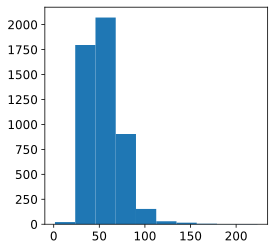

In [70]:
test_df.loc[:, 'Square'].\
    hist(figsize=(4,4), bins=10, grid=False);

Проверим значения площади меньше 15

In [71]:
test_df[test_df['Square'] <= 15]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
2      5480        190    1.0  13.597819   15.948246           12.0      2   
66     9011         53    1.0   1.378543    1.353573            1.0      1   
608   16401         30    1.0   2.645046    4.338755            1.0      2   
837    2138         27    1.0   5.647458    1.501582            1.0      1   
1165  10120          6    1.0   5.100672    3.861780            1.0      3   
3697  15435         21    1.0  13.305531    9.495367            0.0      6   
4490   1165         27    1.0   2.372101    1.899119            1.0      2   
4540   7855          6    1.0   4.967143    2.968086            1.0      3   
4713    170          6    2.0   2.900586   61.468563            1.0     18   
4902   1420         45    1.0   1.975769    2.900371            1.0      1   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
2            5.0       1909   0.000000         B         B        30   
66           1.0       1977   0.049637         B         B        34   
608          1.0       1977   0.000078         B         B        22   
837          1.0       1977   0.017647         B         B         2   
1165         1.0       1977   0.243205         B         B         5   
3697         5.0       1965   0.194489         B         B        47   
4490        17.0       1977   0.011654         B         B         4   
4540         1.0       2018   0.243205         B         B         5   
4713        17.0       2014   0.243205         B         B         5   
4902         1.0       1977   0.195781         B         B        23   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
2         7538        87        4702.0            5        5       B  
66        7759         0         229.0            1        3       B  
608       6398       141        1046.0            3       23       B  
837        469         0           NaN            0        0       B  
1165      1564         0         540.0            0        0       B  
3697      8004         3         125.0            3        5       B  
4490       915         0           NaN            0        0       B  
4540      1564         0         540.0            0        0       B  
4713      1564         0         540.0            0        0       B  
4902      5212         6           NaN            3        2       B

Заменим значения площади меньше 15 на медианное значение группы (в заисимости от того, сколько комнат в той или иной квартире)

In [72]:
test_df.loc[test_df['Square'] <= 15 , 'Square'] = None
test_df['Square'].fillna(test_df.groupby('Rooms')['Square'].transform('median'), inplace=True)
test_df[test_df['Square'] <= 15].shape

(0, 19)

***KitchenSquare***

Теперь проверим на наличие выбросов в признаке KitchenSquare

In [73]:
test_df.describe()

Rooms       Square   LifeSquare  KitchenSquare        Floor  \
count  5000.000000  5000.000000  3959.000000    5000.000000  5000.000000   
mean      1.906200    56.522211    36.158810       5.976800     8.632000   
std       0.805935    18.967194    17.825287       9.950018     5.483228   
min       1.000000    16.319015     0.333490       0.000000     1.000000   
25%       1.000000    41.912403    23.092026       1.000000     4.000000   
50%       2.000000    52.924953    32.925087       6.000000     7.000000   
75%       2.000000    66.285129    45.174091       9.000000    12.000000   
max       5.000000   223.453689   303.071094     620.000000    78.000000   

        HouseFloor    HouseYear    Ecology_1     Social_1      Social_2  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean     12.601000  1984.392600     0.119874    24.933800   5406.900000   
std       6.789213    18.573149     0.120070    17.532202   4026.614773   
min       0.000000  1908.000000     0.000000     0.000000    168.000000   
25%       9.000000  1973.000000     0.019509     6.000000   1564.000000   
50%      12.000000  1977.000000     0.072158    25.000000   5285.000000   
75%      17.000000  2000.000000     0.195781    36.000000   7287.000000   
max      99.000000  2020.000000     0.521867    74.000000  19083.000000   

          Social_3  Healthcare_1  Helthcare_2      Shops_1  
count  5000.000000   2623.000000   5000.00000  5000.000000  
mean      8.262600   1146.657263      1.31940     4.242800  
std      23.863762   1044.744231      1.47994     4.777365  
min       0.000000      0.000000      0.00000     0.000000  
25%       0.000000    325.000000      0.00000     1.000000  
50%       2.000000    900.000000      1.00000     3.000000  
75%       5.000000   1548.000000      2.00000     6.000000  
max     141.000000   4849.000000      6.00000    23.000000

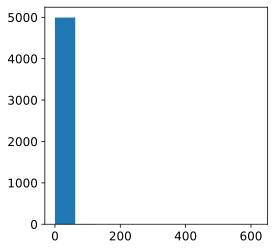

In [74]:
test_df.loc[:, 'KitchenSquare'].\
    hist(figsize=(4,4), bins=10, grid=False);

In [75]:
test_df[test_df['KitchenSquare'] > test_df['Square']]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1964  14594         11    2.0  42.795304   24.223770          620.0     11   
2424  10662         29    1.0  25.956829   17.251768           33.0      5   
3863   3194         29    2.0  43.926987   31.028707           44.0      6   
4555  12640          6    2.0  54.629142   31.486308           97.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1964        14.0       1972   0.038693         B         B        28   
2424         5.0       1973   0.069660         B         B        31   
3863         5.0       1964   0.086885         B         B        10   
4555        17.0       2015   0.243205         B         B         5   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
1964      6533         1        1015.0            2        5       B  
2424      6119         4           NaN            1        2       B  
3863      2277         2        1547.0            0        0       B  
4555      1564         0         540.0            0        0       B

Заменим такие значения на разность между Square и LifeSqaure

In [76]:
test_df.loc[(test_df['KitchenSquare'] > test_df['Square']), 'KitchenSquare'] = \
                          test_df.loc[(test_df['KitchenSquare'] > test_df['Square']), 'Square'] - \
                          test_df.loc[(test_df['KitchenSquare'] > test_df['Square']), 'LifeSquare']
test_df[(test_df['KitchenSquare'] > test_df['Square'])].shape

(0, 19)

Теперь рассмотрим такие случаи, когда отношение кухонной площади от общей площади составляет более 70%

In [77]:
test_df[(test_df['KitchenSquare'] / test_df['Square'] >= 0.7)]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
40     5428         27    2.0   62.326044         NaN           61.0     12   
1456   5260         73    3.0   69.358242   51.247581           65.0      6   
1777   3341         62    3.0  112.114019  112.247841          112.0      3   
3723   4483         62    1.0   41.951462   45.672140           41.0     13   
3816  12612         27    2.0   60.988496   33.646726           60.0      5   
3927   6568         78    1.0   46.827201   40.227011           40.0      5   
4281   8015         27    1.0   66.099096   33.639611           62.0      3   
4405   5199         27    2.0   59.054990   61.647531           57.0     13   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
40          17.0       1977   0.072158         B         B         2   
1456         6.0       1931   0.042032         B         B        37   
1777         3.0       2017   0.072158         B         B         2   
3723        17.0       2018   0.072158         B         B         2   
3816        17.0       2013   0.072158         B         B         2   
3927        32.0       2007   0.219006         B         B        28   
4281         7.0       2016   0.014058         B         B         1   
4405        12.0       2016   0.211401         B         B         9   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
40         629         1           NaN            0        0       A  
1456      6856        84        1940.0            2        5       B  
1777       629         1           NaN            0        0       A  
3723       629         1           NaN            0        0       A  
3816       629         1           NaN            0        0       A  
3927      6746         3           NaN            1        4       B  
4281       290         0           NaN            0        0       B  
4405      1892         0           NaN            0        1       B

Заменим такие случаи на медианное отношение между кухонной площадью и общей площадью по всей выборке

In [78]:
test_df.loc[(test_df['KitchenSquare'] / test_df['Square']) >= 0.7, 'KitchenSquare'] = None
median_value = (test_df['KitchenSquare'] / test_df['Square']).dropna().median()
median_value

0.12010466347885787

In [79]:
test_df.loc[test_df['KitchenSquare'].isnull(), 'KitchenSquare']= \
                  median_value * \
                  test_df.loc[test_df['KitchenSquare'].isnull(), 'Square']
test_df[(test_df['KitchenSquare'] / test_df['Square'] >= 0.7)].shape

(0, 19)

Рассмотрим случаи, когда площадь кухни меньше 4

In [80]:
test_df.loc[test_df['KitchenSquare'] < 4 , :].head(10)

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1   15856         74    2.0  69.263183         NaN            1.0      6   
4   14275         27    1.0  47.527111   43.387569            1.0     17   
5    7633         53    1.0  40.675627         NaN            1.0     21   
6   13329         23    2.0  68.099538   64.843025            1.0      2   
11   3310          6    3.0  84.625350         NaN            1.0      6   
14   5214         27    1.0  37.555197         NaN            1.0      5   
18   3495         27    3.0  82.652818    5.690155            1.0      4   
21  16688          1    1.0  44.878767         NaN            1.0      1   
22  12694         27    3.0  83.670032   46.358356            0.0      8   
24   8968         27    2.0  69.849239         NaN            0.0      3   

    HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
1          1.0       1977   0.075779         B         B         6      1437   
4         17.0       2017   0.072158         B         B         2       629   
5         21.0       1977   0.049637         B         B        34      7759   
6         17.0       1977   0.075779         B         B         6      1437   
11        17.0       1977   0.243205         B         B         5      1564   
14         1.0       1977   0.211401         B         B         9      1892   
18        17.0       2015   0.072158         B         B         2       629   
21         9.0       1977   0.007122         B         B         1       264   
22         0.0       2015   0.072158         B         B         2       629   
24         0.0       1977   0.011654         B         B         4       915   

    Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
1          3           NaN            0        2       B  
4          1           NaN            0        0       A  
5          0         229.0            1        3       B  
6          3           NaN            0        2       B  
11         0         540.0            0        0       B  
14         0           NaN            0        1       B  
18         1           NaN            0        0       A  
21         0           NaN            0        1       B  
22         1           NaN            0        0       A  
24         0           NaN            0        0       B

Также заменим такие случаи на медианное отношение между кухонной площадью и общей площадью по всей выборке

In [81]:
test_df.loc[test_df['KitchenSquare'] < 4 , 'KitchenSquare'] = None
test_df.loc[test_df['KitchenSquare'].isnull() , 'KitchenSquare'] = ((test_df['KitchenSquare'].dropna() / test_df['Square']).median() * \
                                test_df.loc[test_df['KitchenSquare'].isnull() , 'Square']) 

In [82]:
test_df.loc[test_df['KitchenSquare'] < 4 , 'KitchenSquare']

58      3.120115
282     3.515365
557     2.769749
627     3.683939
1195    2.639634
1340    3.444271
1441    2.512291
1573    3.671519
2647    3.206939
2744    2.373442
2895    2.787627
3435    3.139898
3656    3.128644
3748    3.182464
4234    3.886123
4457    3.152373
Name: KitchenSquare, dtype: float64

Оставшиеся случаи заменим на 4

In [83]:
test_df.loc[test_df['KitchenSquare'] < 4 , 'KitchenSquare'] = 4
test_df.loc[test_df['KitchenSquare'] < 4 , 'KitchenSquare'].shape

(0,)

***LifeSquare***

Теперь рассмотрим переменную LifeSquare

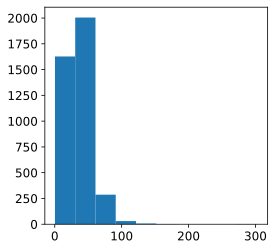

In [84]:
test_df.loc[:, 'LifeSquare'].\
    hist(figsize=(4,4), bins=10, grid=False);

Рассмотрим случаи, когда сумма площадей LifeSquare и KitchenSquare больше общей площади недвижимости

In [85]:
test_df[test_df['LifeSquare'] + test_df['KitchenSquare'] > test_df['Square']].head(10)

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
4   14275         27    1.0  47.527111   43.387569       6.912355     17   
6   13329         23    2.0  68.099538   64.843025       9.904414      2   
27  11160         58    1.0  48.610661   48.752502       7.069947      4   
29    891         85    2.0  65.550690   61.689280      10.000000     13   
39   6624         27    1.0  42.413793   42.434887      10.000000     12   
43  11513          1    1.0  37.484057   40.593036       5.451691      4   
45   9519         62    3.0  81.912997   75.872094      11.000000      3   
55   5452         27    1.0  48.587913   42.596190      12.000000      3   
65  10929         48    1.0  40.767892   37.236548       5.929293     20   
70   1872         30    2.0  52.449057   52.798349       7.628204     17   

    HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
4         17.0       2017   0.072158         B         B         2       629   
6         17.0       1977   0.075779         B         B         6      1437   
27         3.0       1977   0.437885         B         B        23      5735   
29        22.0       1988   0.037178         B         B        52     11217   
39        17.0       2017   0.011654         B         B         4       915   
43        17.0       1977   0.007122         B         B         1       264   
45         6.0       2015   0.072158         B         B         2       629   
55         2.0       2016   0.017647         B         B         2       469   
65        19.0       2017   0.041125         B         B        46      9515   
70        17.0       2016   0.000078         B         B        22      6398   

    Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
4          1           NaN            0        0       A  
6          3           NaN            0        2       B  
27         3        1084.0            0        5       B  
29         1        2300.0            1        7       B  
39         0           NaN            0        0       B  
43         0           NaN            0        1       B  
45         1           NaN            0        0       A  
55         0           NaN            0        0       B  
65         5           NaN            1       10       B  
70       141        1046.0            3       23       B

Заменим такие случаи на разность между общей площадью и площадью кухни

In [86]:
test_df.loc[(test_df['LifeSquare'] + test_df['KitchenSquare'] > test_df['Square']),'LifeSquare'] = \
           test_df.loc[(test_df['LifeSquare'] + test_df['KitchenSquare'] > test_df['Square']),'Square'] - \
           test_df.loc[(test_df['LifeSquare'] + test_df['KitchenSquare'] > test_df['Square']),'KitchenSquare']

Рассмотрим случаи, когда отношение суммы жилой и кухонной площадей от общей площади квартиры - меньше 50%

In [87]:
test_df[((test_df['LifeSquare'] + test_df['KitchenSquare']) / test_df['Square']) < 0.5].head(10)

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
18    3495         27    3.0   82.652818    5.690155      12.021047      4   
66    9011         53    1.0   40.177187    1.353573       5.843380      1   
71    9205        120    2.0   85.911827    4.188395      12.495038      5   
77    7034         45    2.0   59.927502    3.798341       8.715871     23   
78    6553         34    5.0  122.375273    0.333490      17.798291      9   
153   1105          9    3.0  105.351051    5.589869      15.322283     11   
237   5857         26    1.0   56.688460    2.132381       8.244784      8   
259  13706         23    3.0   81.003455    2.366869      11.781163      5   
325    940         27    1.0   48.674779    2.912992       7.079272      7   
326  14959          1    2.0   64.112441    1.181139       9.324530     13   

     HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
18         17.0       2015   0.072158         B         B         2       629   
66          1.0       1977   0.049637         B         B        34      7759   
71          1.0       2016   0.341072         B         B        27      5664   
77          1.0       2017   0.195781         B         B        23      5212   
78          0.0       1977   0.069753         B         B        53     13670   
153         1.0       1977   0.161532         B         B        25      5648   
237        20.0       2013   0.000000         B         B        36      6714   
259         5.0       2017   0.034656         B         B         0       168   
325        17.0       2016   0.072158         B         B         2       629   
326        17.0       1977   0.007122         B         B         1       264   

     Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
18          1           NaN            0        0       A  
66          0         229.0            1        3       B  
71         48        2300.0            3       11       B  
77          6           NaN            3        2       B  
78          4           NaN            1       11       B  
153         1          30.0            2        4       B  
237         2        2672.0            0        2       B  
259         0           NaN            0        0       B  
325         1           NaN            0        0       A  
326         0           NaN            0        1       B

Заменим значения LifeSquare для такой выборки на разность между общей площадью и квартирной площадью

In [88]:
test_df.loc[((test_df['LifeSquare'] + test_df['KitchenSquare']) / test_df['Square']) < 0.5, 'LifeSquare'] = \
         test_df.loc[((test_df['LifeSquare'] + test_df['KitchenSquare']) / test_df['Square']) < 0.5, 'Square'] - \
         test_df.loc[((test_df['LifeSquare'] + test_df['KitchenSquare']) / test_df['Square']) < 0.5, 'KitchenSquare']

In [89]:
test_df[((test_df['LifeSquare'] + test_df['KitchenSquare']) / test_df['Square']) < 0.5].shape

(0, 19)

In [90]:
test_df.describe()

Rooms       Square   LifeSquare  KitchenSquare        Floor  \
count  5000.000000  5000.000000  3959.000000    5000.000000  5000.000000   
mean      1.906200    56.522211    36.355383       8.199615     8.632000   
std       0.805935    18.967194    15.374807       2.750721     5.483228   
min       1.000000    16.319015     9.698766       4.000000     1.000000   
25%       1.000000    41.912403    23.842988       6.000000     4.000000   
50%       2.000000    52.924953    33.243780       8.000000     7.000000   
75%       2.000000    66.285129    45.155245      10.000000    12.000000   
max       5.000000   223.453689   164.974480      42.000000    78.000000   

        HouseFloor    HouseYear    Ecology_1     Social_1      Social_2  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean     12.601000  1984.392600     0.119874    24.933800   5406.900000   
std       6.789213    18.573149     0.120070    17.532202   4026.614773   
min       0.000000  1908.000000     0.000000     0.000000    168.000000   
25%       9.000000  1973.000000     0.019509     6.000000   1564.000000   
50%      12.000000  1977.000000     0.072158    25.000000   5285.000000   
75%      17.000000  2000.000000     0.195781    36.000000   7287.000000   
max      99.000000  2020.000000     0.521867    74.000000  19083.000000   

          Social_3  Healthcare_1  Helthcare_2      Shops_1  
count  5000.000000   2623.000000   5000.00000  5000.000000  
mean      8.262600   1146.657263      1.31940     4.242800  
std      23.863762   1044.744231      1.47994     4.777365  
min       0.000000      0.000000      0.00000     0.000000  
25%       0.000000    325.000000      0.00000     1.000000  
50%       2.000000    900.000000      1.00000     3.000000  
75%       5.000000   1548.000000      2.00000     6.000000  
max     141.000000   4849.000000      6.00000    23.000000

***HouseYear***

Рассмотрим уникальные значения для данной переменной (ничего заменять не надо)

In [91]:
test_df['HouseYear'].value_counts().sort_index()

1908      1
1909      1
1910      1
1911      1
1912      1
       ... 
2016    172
2017    141
2018     73
2019     28
2020      9
Name: HouseYear, Length: 97, dtype: int64

***Floor, Housefloor***

Рассмотрим значения, когда House floor = 0 и заменим их на медиану

In [92]:
test_df[test_df['HouseFloor'] == 0].head(10)

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
22   12694         27    3.0   83.670032   46.358356      12.168991      8   
24    8968         27    2.0   69.849239         NaN      10.158891      3   
30    2982          6    2.0   63.460684         NaN       9.229738     13   
32    2449          1    1.0   66.426585         NaN       9.661099     14   
46   12309         45    1.0   42.899569         NaN       6.239324     25   
78    6553         34    5.0  122.375273  104.576983      17.798291      9   
113   5032         30    1.0   50.738045         NaN       7.379354      5   
120  12743         27    1.0   40.407390         NaN       5.876861      9   
130   5746         62    1.0   44.021356         NaN       6.402477     13   
132  14834         27    3.0   56.310351         NaN       8.189792     19   

     HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
22          0.0       2015   0.072158         B         B         2       629   
24          0.0       1977   0.011654         B         B         4       915   
30          0.0       1977   0.243205         B         B         5      1564   
32          0.0       1977   0.007122         B         B         1       264   
46          0.0       1977   0.195781         B         B        23      5212   
78          0.0       1977   0.069753         B         B        53     13670   
113         0.0       1977   0.000078         B         B        22      6398   
120         0.0       1977   0.211401         B         B         9      1892   
130         0.0       1977   0.072158         B         B         2       629   
132         0.0       1977   0.072158         B         B         2       629   

     Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
22          1           NaN            0        0       A  
24          0           NaN            0        0       B  
30          0         540.0            0        0       B  
32          0           NaN            0        1       B  
46          6           NaN            3        2       B  
78          4           NaN            1       11       B  
113       141        1046.0            3       23       B  
120         0           NaN            0        1       B  
130         1           NaN            0        0       A  
132         1           NaN            0        0       A

In [93]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()
test_df[test_df['HouseFloor'] == 0].shape

(0, 19)

Рассмотрим случаи, когда этаж квартиры выше этажности жилого дома

In [94]:
test_df[test_df['Floor'] > test_df['HouseFloor']].head(10)

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1   15856         74    2.0  69.263183         NaN      10.073655      6   
10  15975         61    3.0  64.543658   42.651541       7.000000     10   
14   5214         27    1.0  37.555197         NaN       5.462037      5   
27  11160         58    1.0  48.610661   41.540715       7.069947      4   
30   2982          6    2.0  63.460684         NaN       9.229738     13   
32   2449          1    1.0  66.426585         NaN       9.661099     14   
36   9348        205    1.0  37.480811   16.851795       8.000000      6   
41  12749         21    2.0  49.011976   27.980195       5.000000      6   
46  12309         45    1.0  42.899569         NaN       6.239324     25   
55   5452         27    1.0  48.587913   36.587913      12.000000      3   

    HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
1          1.0       1977   0.075779         B         B         6      1437   
10         9.0       1981   0.300323         B         B        52     10311   
14         1.0       1977   0.211401         B         B         9      1892   
27         3.0       1977   0.437885         B         B        23      5735   
30        12.0       1977   0.243205         B         B         5      1564   
32        12.0       1977   0.007122         B         B         1       264   
36         5.0       1933   0.169091         B         B        19      3856   
41         5.0       1969   0.194489         B         B        47      8004   
46        12.0       1977   0.195781         B         B        23      5212   
55         2.0       2016   0.017647         B         B         2       469   

    Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
1          3           NaN            0        2       B  
10         6           NaN            1        9       B  
14         0           NaN            0        1       B  
27         3        1084.0            0        5       B  
30         0         540.0            0        0       B  
32         0           NaN            0        1       B  
36        10           NaN            2        5       B  
41         3         125.0            3        5       B  
46         6           NaN            3        2       B  
55         0           NaN            0        0       B

Заменим такие значения Floor на этажность жилого комлпекса, в котором находится та или иная квартира

In [95]:
floor_outliers = test_df[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[floor_outliers, 'Floor'] = test_df.loc[floor_outliers, 'HouseFloor']
test_df[test_df['Floor'] > test_df['HouseFloor']].shape

(0, 19)

***Social_3***

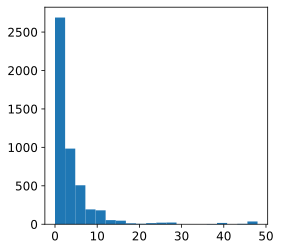

In [96]:
test_df.loc[test_df['Social_3'] < 50, 'Social_3'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [97]:
test_df.loc[test_df['Social_3'] > 15, 'Social_3'] = test_df['Social_3'].median()

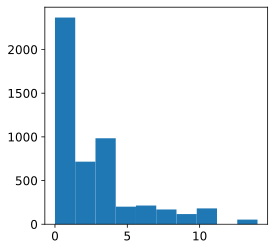

In [98]:
test_df.loc[test_df['Social_3'] < 20, 'Social_3'].\
    hist(figsize=(4,4), bins=10, grid=False);

Рассмотрим, насколько поменялась статистика после удаления выбросов

In [99]:
test_df.describe()

Rooms       Square   LifeSquare  KitchenSquare        Floor  \
count  5000.000000  5000.000000  3959.000000    5000.000000  5000.000000   
mean      1.906200    56.522211    36.355383       8.199615     8.046200   
std       0.805935    18.967194    15.374807       2.750721     5.330567   
min       1.000000    16.319015     9.698766       4.000000     1.000000   
25%       1.000000    41.912403    23.842988       6.000000     4.000000   
50%       2.000000    52.924953    33.243780       8.000000     7.000000   
75%       2.000000    66.285129    45.155245      10.000000    12.000000   
max       5.000000   223.453689   164.974480      42.000000    46.000000   

        HouseFloor    HouseYear    Ecology_1     Social_1      Social_2  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean     12.915400  1984.392600     0.119874    24.933800   5406.900000   
std       6.468617    18.573149     0.120070    17.532202   4026.614773   
min       1.000000  1908.000000     0.000000     0.000000    168.000000   
25%       9.000000  1973.000000     0.019509     6.000000   1564.000000   
50%      12.000000  1977.000000     0.072158    25.000000   5285.000000   
75%      17.000000  2000.000000     0.195781    36.000000   7287.000000   
max      99.000000  2020.000000     0.521867    74.000000  19083.000000   

          Social_3  Healthcare_1  Helthcare_2      Shops_1  
count  5000.000000   2623.000000   5000.00000  5000.000000  
mean      2.593000   1146.657263      1.31940     4.242800  
std       2.972527   1044.744231      1.47994     4.777365  
min       0.000000      0.000000      0.00000     0.000000  
25%       0.000000    325.000000      0.00000     1.000000  
50%       2.000000    900.000000      1.00000     3.000000  
75%       4.000000   1548.000000      2.00000     6.000000  
max      14.000000   4849.000000      6.00000    23.000000

#### Обработка пропусков (для тестового датасета)

In [100]:
test_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

***LifeSquare***

In [101]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = test_df.loc[test_df['LifeSquare'].isnull(), 'Square'] - \
                                                            test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare']
test_df['LifeSquare'].isnull().sum()

0

***Healthcare_1***

In [102]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()
test_df['Healthcare_1'].isnull().sum()

0

Рассмотрим, как изменилиось распредление значений признаков после обработки выбросов и пропусков

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

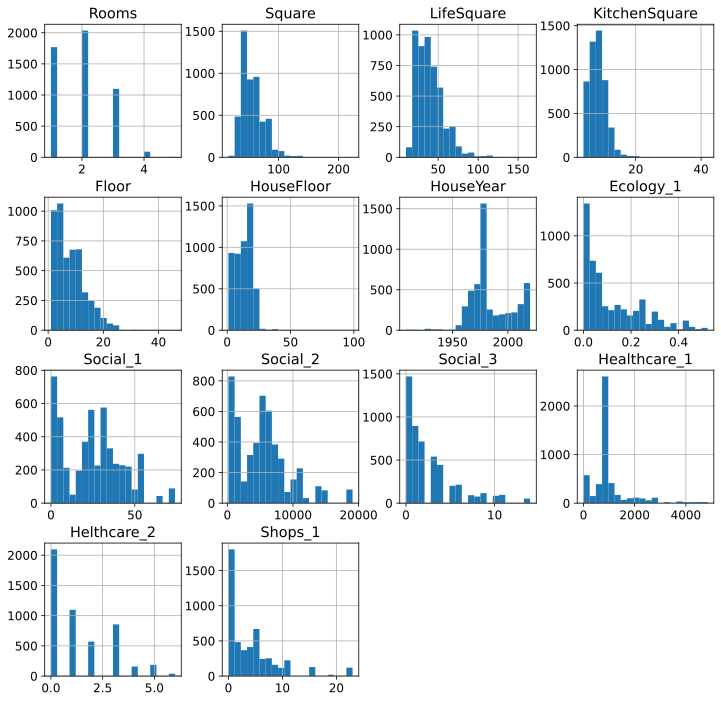

In [103]:
df_num_features = test_df.select_dtypes(include=['float64', 'int64'])
df_num_features.hist(figsize=(12,12), bins=20, grid=True)

### Матрица корреляций <a class='anchor' id='correlation_matrix'>

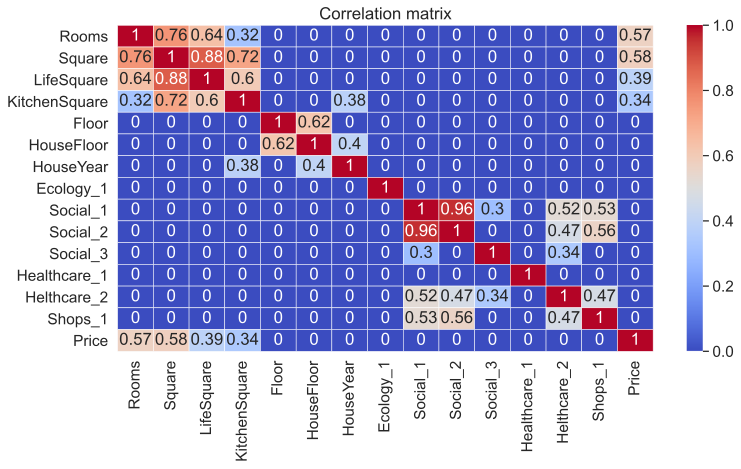

In [104]:
plt.figure(figsize = (12,6))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Добавление новых признаков (для тренировочного датасета) <a class='anchor' id='new_variables'>

#### Дамми-переменные

In [105]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'], prefix='Ecology_2_'),
                pd.get_dummies(train_df['Ecology_3'], prefix='Ecology_3_'),
               pd.get_dummies(train_df['Shops_2'], prefix='Shops_2_')], axis=1)
train_df.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35    2.0  47.981561   29.442751       6.000000    7.0   
1  15053         41    3.0  65.683640   40.049543       8.000000    7.0   
2   4765         53    2.0  44.947953   29.197612       6.644164    8.0   
3   5809         58    2.0  53.352981   44.352981       9.000000    8.0   
4  10783         99    1.0  39.649192   23.776169       7.000000   11.0   

   HouseFloor  HouseYear  Ecology_1  ... Helthcare_2 Shops_1  Shops_2  \
0         9.0       1969   0.089040  ...           0      11        B   
1         9.0       1978   0.000070  ...           1      16        B   
2        12.0       1968   0.049637  ...           1       3        B   
3        17.0       1977   0.437885  ...           0       5        B   
4        12.0       1976   0.012339  ...           2       4        B   

           Price  Ecology_2__A  Ecology_2__B  Ecology_3__A  Ecology_3__B  \
0  184966.930730             0             1             0             1   
1  300009.450063             0             1             0             1   
2  220925.908524             0             1             0             1   
3  175616.227217             0             1             0             1   
4  150226.531644             0             1             0             1   

  Shops_2__A  Shops_2__B  
0          0           1  
1          0           1  
2          0           1  
3          0           1  
4          0           1  

[5 rows x 26 columns]

#### Добавление признаков DistrictSize и TypeofPopulation (underpopulated, mediumpopulated, overpopulated)

In [106]:
district_size = train_df['DistrictId'].value_counts().reset_index()


In [107]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head(10)

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35    2.0  47.981561   29.442751       6.000000    7.0   
1  15053         41    3.0  65.683640   40.049543       8.000000    7.0   
2   4765         53    2.0  44.947953   29.197612       6.644164    8.0   
3   5809         58    2.0  53.352981   44.352981       9.000000    8.0   
4  10783         99    1.0  39.649192   23.776169       7.000000   11.0   
5  12915         59    3.0  80.384479   46.683720      12.000000    5.0   
6  14549        154    2.0  62.254114   37.160377       7.000000    3.0   
7  11993         74    2.0  80.312926   68.441144      11.871781   13.0   
8   5172          1    2.0  64.511437   54.975417       9.536020    9.0   
9   8649         23    1.0  46.461409   18.915552       8.000000   13.0   

   HouseFloor  HouseYear  Ecology_1  ... Shops_1 Shops_2          Price  \
0         9.0       1969   0.089040  ...      11       B  184966.930730   
1         9.0       1978   0.000070  ...      16       B  300009.450063   
2        12.0       1968   0.049637  ...       3       B  220925.908524   
3        17.0       1977   0.437885  ...       5       B  175616.227217   
4        12.0       1976   0.012339  ...       4       B  150226.531644   
5        17.0       2011   0.309479  ...       6       B  215898.447742   
6         5.0       1960   0.460556  ...       5       B  296021.204377   
7        13.0       1977   0.075779  ...       2       B  221244.156664   
8        17.0       1977   0.007122  ...       1       B  229102.795999   
9        17.0       2014   0.075779  ...       2       B   95380.220993   

   Ecology_2__A  Ecology_2__B  Ecology_3__A  Ecology_3__B  Shops_2__A  \
0             0             1             0             1           0   
1             0             1             0             1           0   
2             0             1             0             1           0   
3             0             1             0             1           0   
4             0             1             0             1           0   
5             0             1             0             1           0   
6             0             1             0             1           0   
7             0             1             0             1           0   
8             0             1             0             1           0   
9             0             1             0             1           0   

  Shops_2__B  DistrictSize  
0          1            22  
1          1            87  
2          1           174  
3          1           179  
4          1            97  
5          1            67  
6          1            10  
7          1           114  
8          1           652  
9          1           565  

[10 rows x 27 columns]

In [108]:
train_df['D_Underpopulated'] = ((train_df['DistrictSize'] > 0) & (train_df['DistrictSize'] <= 100)).astype(int)
train_df['D_Mediumpopulated'] = ((train_df['DistrictSize'] > 100) & (train_df['DistrictSize'] <= 200)).astype(int)
train_df['D_Overpopulated'] = (train_df['DistrictSize'] > 200).astype(int)
train_df.head(10)

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35    2.0  47.981561   29.442751       6.000000    7.0   
1  15053         41    3.0  65.683640   40.049543       8.000000    7.0   
2   4765         53    2.0  44.947953   29.197612       6.644164    8.0   
3   5809         58    2.0  53.352981   44.352981       9.000000    8.0   
4  10783         99    1.0  39.649192   23.776169       7.000000   11.0   
5  12915         59    3.0  80.384479   46.683720      12.000000    5.0   
6  14549        154    2.0  62.254114   37.160377       7.000000    3.0   
7  11993         74    2.0  80.312926   68.441144      11.871781   13.0   
8   5172          1    2.0  64.511437   54.975417       9.536020    9.0   
9   8649         23    1.0  46.461409   18.915552       8.000000   13.0   

   HouseFloor  HouseYear  Ecology_1  ... Ecology_2__A Ecology_2__B  \
0         9.0       1969   0.089040  ...            0            1   
1         9.0       1978   0.000070  ...            0            1   
2        12.0       1968   0.049637  ...            0            1   
3        17.0       1977   0.437885  ...            0            1   
4        12.0       1976   0.012339  ...            0            1   
5        17.0       2011   0.309479  ...            0            1   
6         5.0       1960   0.460556  ...            0            1   
7        13.0       1977   0.075779  ...            0            1   
8        17.0       1977   0.007122  ...            0            1   
9        17.0       2014   0.075779  ...            0            1   

   Ecology_3__A  Ecology_3__B  Shops_2__A  Shops_2__B  DistrictSize  \
0             0             1           0           1            22   
1             0             1           0           1            87   
2             0             1           0           1           174   
3             0             1           0           1           179   
4             0             1           0           1            97   
5             0             1           0           1            67   
6             0             1           0           1            10   
7             0             1           0           1           114   
8             0             1           0           1           652   
9             0             1           0           1           565   

   D_Underpopulated D_Mediumpopulated  D_Overpopulated  
0                 1                 0                0  
1                 1                 0                0  
2                 0                 1                0  
3                 0                 1                0  
4                 1                 0                0  
5                 1                 0                0  
6                 1                 0                0  
7                 0                 1                0  
8                 0                 0                1  
9                 0                 0                1  

[10 rows x 30 columns]

In [109]:
dummies = train_df.loc[:, ['D_Underpopulated', 'D_Mediumpopulated', 'D_Overpopulated']]
dummies = dummies.stack()
train_df['TypeofPopulation'] = pd.DataFrame(pd.Categorical(dummies[dummies!=0].index.get_level_values(1)), columns=['TypeofPopulation'])
train_df.head(10)

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35    2.0  47.981561   29.442751       6.000000    7.0   
1  15053         41    3.0  65.683640   40.049543       8.000000    7.0   
2   4765         53    2.0  44.947953   29.197612       6.644164    8.0   
3   5809         58    2.0  53.352981   44.352981       9.000000    8.0   
4  10783         99    1.0  39.649192   23.776169       7.000000   11.0   
5  12915         59    3.0  80.384479   46.683720      12.000000    5.0   
6  14549        154    2.0  62.254114   37.160377       7.000000    3.0   
7  11993         74    2.0  80.312926   68.441144      11.871781   13.0   
8   5172          1    2.0  64.511437   54.975417       9.536020    9.0   
9   8649         23    1.0  46.461409   18.915552       8.000000   13.0   

   HouseFloor  HouseYear  Ecology_1  ... Ecology_2__B Ecology_3__A  \
0         9.0       1969   0.089040  ...            1            0   
1         9.0       1978   0.000070  ...            1            0   
2        12.0       1968   0.049637  ...            1            0   
3        17.0       1977   0.437885  ...            1            0   
4        12.0       1976   0.012339  ...            1            0   
5        17.0       2011   0.309479  ...            1            0   
6         5.0       1960   0.460556  ...            1            0   
7        13.0       1977   0.075779  ...            1            0   
8        17.0       1977   0.007122  ...            1            0   
9        17.0       2014   0.075779  ...            1            0   

   Ecology_3__B  Shops_2__A  Shops_2__B  DistrictSize  D_Underpopulated  \
0             1           0           1            22                 1   
1             1           0           1            87                 1   
2             1           0           1           174                 0   
3             1           0           1           179                 0   
4             1           0           1            97                 1   
5             1           0           1            67                 1   
6             1           0           1            10                 1   
7             1           0           1           114                 0   
8             1           0           1           652                 0   
9             1           0           1           565                 0   

   D_Mediumpopulated D_Overpopulated   TypeofPopulation  
0                  0               0   D_Underpopulated  
1                  0               0   D_Underpopulated  
2                  1               0  D_Mediumpopulated  
3                  1               0  D_Mediumpopulated  
4                  0               0   D_Underpopulated  
5                  0               0   D_Underpopulated  
6                  0               0   D_Underpopulated  
7                  1               0  D_Mediumpopulated  
8                  0               1    D_Overpopulated  
9                  0               1    D_Overpopulated  

[10 rows x 31 columns]

In [110]:
train_df['TypeofPopulation'].value_counts().sort_index()

D_Mediumpopulated    1721
D_Overpopulated      3348
D_Underpopulated     4931
Name: TypeofPopulation, dtype: int64

In [111]:
train_df.head(10)

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35    2.0  47.981561   29.442751       6.000000    7.0   
1  15053         41    3.0  65.683640   40.049543       8.000000    7.0   
2   4765         53    2.0  44.947953   29.197612       6.644164    8.0   
3   5809         58    2.0  53.352981   44.352981       9.000000    8.0   
4  10783         99    1.0  39.649192   23.776169       7.000000   11.0   
5  12915         59    3.0  80.384479   46.683720      12.000000    5.0   
6  14549        154    2.0  62.254114   37.160377       7.000000    3.0   
7  11993         74    2.0  80.312926   68.441144      11.871781   13.0   
8   5172          1    2.0  64.511437   54.975417       9.536020    9.0   
9   8649         23    1.0  46.461409   18.915552       8.000000   13.0   

   HouseFloor  HouseYear  Ecology_1  ... Ecology_2__B Ecology_3__A  \
0         9.0       1969   0.089040  ...            1            0   
1         9.0       1978   0.000070  ...            1            0   
2        12.0       1968   0.049637  ...            1            0   
3        17.0       1977   0.437885  ...            1            0   
4        12.0       1976   0.012339  ...            1            0   
5        17.0       2011   0.309479  ...            1            0   
6         5.0       1960   0.460556  ...            1            0   
7        13.0       1977   0.075779  ...            1            0   
8        17.0       1977   0.007122  ...            1            0   
9        17.0       2014   0.075779  ...            1            0   

   Ecology_3__B  Shops_2__A  Shops_2__B  DistrictSize  D_Underpopulated  \
0             1           0           1            22                 1   
1             1           0           1            87                 1   
2             1           0           1           174                 0   
3             1           0           1           179                 0   
4             1           0           1            97                 1   
5             1           0           1            67                 1   
6             1           0           1            10                 1   
7             1           0           1           114                 0   
8             1           0           1           652                 0   
9             1           0           1           565                 0   

   D_Mediumpopulated D_Overpopulated   TypeofPopulation  
0                  0               0   D_Underpopulated  
1                  0               0   D_Underpopulated  
2                  1               0  D_Mediumpopulated  
3                  1               0  D_Mediumpopulated  
4                  0               0   D_Underpopulated  
5                  0               0   D_Underpopulated  
6                  0               0   D_Underpopulated  
7                  1               0  D_Mediumpopulated  
8                  0               1    D_Overpopulated  
9                  0               1    D_Overpopulated  

[10 rows x 31 columns]

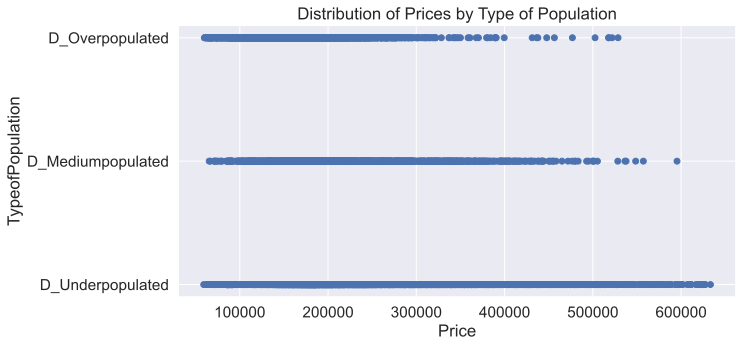

In [112]:
plt.figure(figsize=(10, 5))

plt.scatter(train_df['Price'], train_df['TypeofPopulation'])

plt.xlabel('Price')
plt.ylabel('TypeofPopulation')
plt.title('Distribution of Prices by Type of Population')
plt.show()

### Добавление новых признаков (для тестового датасета) <a class='anchor' id='new_variables_test'>

In [113]:
district_size = test_df['DistrictId'].value_counts().reset_index()
district_size = test_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df.head(10)

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725         58    2.0  49.882643   33.432782       6.000000    6.0   
1  15856         74    2.0  69.263183   59.189529      10.073655    1.0   
2   5480        190    1.0  40.177187   15.948246      12.000000    2.0   
3  15664         47    2.0  73.046609   51.940842       9.000000   22.0   
4  14275         27    1.0  47.527111   40.614756       6.912355   17.0   
5   7633         53    1.0  40.675627   34.759753       5.915873   21.0   
6  13329         23    2.0  68.099538   58.195124       9.904414    2.0   
7   5502         32    2.0  48.193897   32.857644       6.000000    5.0   
8   4220         96    3.0  72.277106   45.968758       9.000000   17.0   
9  11538          6    3.0  80.219400   47.660260       9.000000   13.0   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        14.0       1972   0.310199         B         B        11      2748   
1         1.0       1977   0.075779         B         B         6      1437   
2         5.0       1909   0.000000         B         B        30      7538   
3        22.0       2007   0.101872         B         B        23      4583   
4        17.0       2017   0.072158         B         B         2       629   
5        21.0       1977   0.049637         B         B        34      7759   
6        17.0       1977   0.075779         B         B         6      1437   
7        14.0       1972   0.135650         B         B        46      7960   
8        17.0       1997   0.041116         B         B        53     14892   
9        17.0       2014   0.243205         B         B         5      1564   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  DistrictSize  
0         1         900.0            0        0       B            91  
1         3         900.0            0        2       B            61  
2         2        4702.0            5        5       B             2  
3         3         900.0            3        3       B            49  
4         1         900.0            0        0       A           391  
5         0         229.0            1        3       B            91  
6         3         900.0            0        2       B           264  
7         6         350.0            3       11       B            21  
8         4         900.0            1        4       B            42  
9         0         540.0            0        0       B           257

In [114]:
test_df['D_Underpopulated'] = ((test_df['DistrictSize'] > 0) & (test_df['DistrictSize'] <= 100)).astype(int)
test_df['D_Mediumpopulated'] = ((test_df['DistrictSize'] > 100) & (test_df['DistrictSize'] <= 200)).astype(int)
test_df['D_Overpopulated'] = (test_df['DistrictSize'] > 200).astype(int)
dummies = test_df.loc[:, ['D_Underpopulated', 'D_Mediumpopulated', 'D_Overpopulated']]
dummies = dummies.stack()
test_df['TypeofPopulation'] = pd.DataFrame(pd.Categorical(dummies[dummies!=0].index.get_level_values(1)), columns=['TypeofPopulation'])
test_df.head(10)

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725         58    2.0  49.882643   33.432782       6.000000    6.0   
1  15856         74    2.0  69.263183   59.189529      10.073655    1.0   
2   5480        190    1.0  40.177187   15.948246      12.000000    2.0   
3  15664         47    2.0  73.046609   51.940842       9.000000   22.0   
4  14275         27    1.0  47.527111   40.614756       6.912355   17.0   
5   7633         53    1.0  40.675627   34.759753       5.915873   21.0   
6  13329         23    2.0  68.099538   58.195124       9.904414    2.0   
7   5502         32    2.0  48.193897   32.857644       6.000000    5.0   
8   4220         96    3.0  72.277106   45.968758       9.000000   17.0   
9  11538          6    3.0  80.219400   47.660260       9.000000   13.0   

   HouseFloor  HouseYear  Ecology_1  ... Social_3 Healthcare_1  Helthcare_2  \
0        14.0       1972   0.310199  ...        1        900.0            0   
1         1.0       1977   0.075779  ...        3        900.0            0   
2         5.0       1909   0.000000  ...        2       4702.0            5   
3        22.0       2007   0.101872  ...        3        900.0            3   
4        17.0       2017   0.072158  ...        1        900.0            0   
5        21.0       1977   0.049637  ...        0        229.0            1   
6        17.0       1977   0.075779  ...        3        900.0            0   
7        14.0       1972   0.135650  ...        6        350.0            3   
8        17.0       1997   0.041116  ...        4        900.0            1   
9        17.0       2014   0.243205  ...        0        540.0            0   

   Shops_1  Shops_2  DistrictSize  D_Underpopulated  D_Mediumpopulated  \
0        0        B            91                 1                  0   
1        2        B            61                 1                  0   
2        5        B             2                 1                  0   
3        3        B            49                 1                  0   
4        0        A           391                 0                  0   
5        3        B            91                 1                  0   
6        2        B           264                 0                  0   
7       11        B            21                 1                  0   
8        4        B            42                 1                  0   
9        0        B           257                 0                  0   

  D_Overpopulated  TypeofPopulation  
0               0  D_Underpopulated  
1               0  D_Underpopulated  
2               0  D_Underpopulated  
3               0  D_Underpopulated  
4               1   D_Overpopulated  
5               0  D_Underpopulated  
6               1   D_Overpopulated  
7               0  D_Underpopulated  
8               0  D_Underpopulated  
9               1   D_Overpopulated  

[10 rows x 24 columns]

In [115]:
test_df = pd.concat([test_df, pd.get_dummies(test_df['Ecology_2'], prefix='Ecology_2_'),
                pd.get_dummies(test_df['Ecology_3'], prefix='Ecology_3_'),
               pd.get_dummies(test_df['Shops_2'], prefix='Shops_2_')], axis=1)
test_df.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725         58    2.0  49.882643   33.432782       6.000000    6.0   
1  15856         74    2.0  69.263183   59.189529      10.073655    1.0   
2   5480        190    1.0  40.177187   15.948246      12.000000    2.0   
3  15664         47    2.0  73.046609   51.940842       9.000000   22.0   
4  14275         27    1.0  47.527111   40.614756       6.912355   17.0   

   HouseFloor  HouseYear  Ecology_1  ... D_Underpopulated D_Mediumpopulated  \
0        14.0       1972   0.310199  ...                1                 0   
1         1.0       1977   0.075779  ...                1                 0   
2         5.0       1909   0.000000  ...                1                 0   
3        22.0       2007   0.101872  ...                1                 0   
4        17.0       2017   0.072158  ...                0                 0   

   D_Overpopulated  TypeofPopulation  Ecology_2__A  Ecology_2__B  \
0                0  D_Underpopulated             0             1   
1                0  D_Underpopulated             0             1   
2                0  D_Underpopulated             0             1   
3                0  D_Underpopulated             0             1   
4                1   D_Overpopulated             0             1   

   Ecology_3__A  Ecology_3__B Shops_2__A  Shops_2__B  
0             0             1          0           1  
1             0             1          0           1  
2             0             1          0           1  
3             0             1          0           1  
4             0             1          1           0  

[5 rows x 30 columns]

###  Применение функции для уменьшения объема памяти, который занимает датасет <a class='anchor' id='memory'>

In [116]:
reduce_mem_usage(train_df)
train_df.info(memory_usage='deep')

Memory usage of dataframe is 5.28 MB
Memory usage after optimization is: 2.08 MB
Decreased by 60.6%
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Id                 10000 non-null  category
 1   DistrictId         10000 non-null  category
 2   Rooms              10000 non-null  float32 
 3   Square             10000 non-null  float32 
 4   LifeSquare         10000 non-null  float32 
 5   KitchenSquare      10000 non-null  float32 
 6   Floor              10000 non-null  float32 
 7   HouseFloor         10000 non-null  float32 
 8   HouseYear          10000 non-null  int16   
 9   Ecology_1          10000 non-null  float32 
 10  Ecology_2          10000 non-null  category
 11  Ecology_3          10000 non-null  category
 12  Social_1           10000 non-null  int8    
 13  Social_2           10000 non-null  int16   
 14  Soc

In [117]:
reduce_mem_usage(test_df)
train_df.info(memory_usage='deep')

Memory usage of dataframe is 2.60 MB
Memory usage after optimization is: 1.03 MB
Decreased by 60.3%
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Id                 10000 non-null  category
 1   DistrictId         10000 non-null  category
 2   Rooms              10000 non-null  float32 
 3   Square             10000 non-null  float32 
 4   LifeSquare         10000 non-null  float32 
 5   KitchenSquare      10000 non-null  float32 
 6   Floor              10000 non-null  float32 
 7   HouseFloor         10000 non-null  float32 
 8   HouseYear          10000 non-null  int16   
 9   Ecology_1          10000 non-null  float32 
 10  Ecology_2          10000 non-null  category
 11  Ecology_3          10000 non-null  category
 12  Social_1           10000 non-null  int8    
 13  Social_2           10000 non-null  int16   
 14  Soc

###  Отбор признаков <a class='anchor' id='columns'>

In [118]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2__A',
 'Ecology_2__B',
 'Ecology_3__A',
 'Ecology_3__B',
 'Shops_2__A',
 'Shops_2__B',
 'DistrictSize',
 'D_Underpopulated',
 'D_Mediumpopulated',
 'D_Overpopulated',
 'TypeofPopulation']

In [119]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor','HouseYear',
                 'Ecology_1', 'Ecology_2__A', 'Ecology_2__B', 'Ecology_3__A', 'Ecology_3__B','Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2__A', 'Shops_2__B','DistrictSize', 'D_Underpopulated',
                'D_Mediumpopulated','D_Overpopulated' ]

target_name = 'Price'

In [120]:
train_df.shape

(10000, 31)

### Разбиение на test и train <a class='anchor' id='train_test'>

In [121]:
X = train_df[feature_names]
y = train_df[target_name]

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

### Построение модели <a class='anchor' id='model'>

#### Масштабирование признаков

In [123]:
train_df.describe()

Rooms        Square    LifeSquare  KitchenSquare        Floor  \
count  10000.000000  10000.000000  10000.000000   10000.000000  10000.00000   
mean       1.888400     56.226326     39.206013       8.291250      7.91820   
std        0.811071     19.067640     16.864185       2.752958      5.18638   
min        1.000000     16.117155      8.547242       4.000000      1.00000   
25%        1.000000     41.783181     27.145586       6.000000      4.00000   
50%        2.000000     52.537977     35.387785       8.000000      7.00000   
75%        2.000000     65.900627     48.097655      10.000000     11.00000   
max        5.000000    275.645294    233.949310      43.000000     42.00000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      12.959100   1984.872400      0.118858     24.687000   5352.157400   
std        6.443546     18.416347      0.119026     17.532614   4006.799803   
min        1.000000   1910.000000      0.000000      0.000000    168.000000   
25%        9.000000   1974.000000      0.017647      6.000000   1564.000000   
50%       13.000000   1977.000000      0.075424     25.000000   5285.000000   
75%       17.000000   2001.000000      0.195781     36.000000   7227.000000   
max      117.000000   2020.000000      0.521867     74.000000  19083.000000   

       ...  Ecology_2__A  Ecology_2__B  Ecology_3__A  Ecology_3__B  \
count  ...  10000.000000  10000.000000  10000.000000  10000.000000   
mean   ...      0.009700      0.990300      0.027500      0.972500   
std    ...      0.098012      0.098012      0.163552      0.163552   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      1.000000      0.000000      1.000000   
50%    ...      0.000000      1.000000      0.000000      1.000000   
75%    ...      0.000000      1.000000      0.000000      1.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

         Shops_2__A    Shops_2__B  DistrictSize  D_Underpopulated  \
count  10000.000000  10000.000000  10000.000000      10000.000000   
mean       0.082500      0.917500    242.306600          0.493100   
std        0.275153      0.275153    268.992652          0.499977   
min        0.000000      0.000000      1.000000          0.000000   
25%        0.000000      1.000000     55.000000          0.000000   
50%        0.000000      1.000000    104.000000          0.000000   
75%        0.000000      1.000000    511.000000          1.000000   
max        1.000000      1.000000    851.000000          1.000000   

       D_Mediumpopulated  D_Overpopulated  
count       10000.000000     10000.000000  
mean            0.172100         0.334800  
std             0.377486         0.471944  
min             0.000000         0.000000  
25%             0.000000         0.000000  
50%             0.000000         0.000000  
75%             0.000000         1.000000  
max             1.000000         1.000000  

[8 rows x 25 columns]

In [124]:
cols_for_scale = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                'Healthcare_1', 'Helthcare_2', 'Shops_1', 'DistrictSize']

In [125]:
scaler = RobustScaler()
X_train[cols_for_scale] = scaler.fit_transform(X_train[cols_for_scale])

In [126]:
X_train.describe()

Rooms        Square    LifeSquare  KitchenSquare        Floor  \
count  6700.000000  6.700000e+03  6.700000e+03    6700.000000  6700.000000   
mean     -0.113582  1.458949e-01  1.729151e-01       0.075172     0.129680   
std       0.807910  7.749943e-01  7.749383e-01       0.687236     0.742032   
min      -1.000000 -1.506809e+00 -1.251595e+00      -1.000000    -0.857143   
25%      -1.000000 -4.503510e-01 -4.004088e-01      -0.500000    -0.428571   
50%       0.000000 -7.866311e-08 -8.968709e-08       0.000000     0.000000   
75%       0.000000  5.496490e-01  5.995912e-01       0.500000     0.571429   
max       3.000000  5.699850e+00  5.840331e+00       8.750000     5.000000   

        HouseFloor    HouseYear    Ecology_1  Ecology_2__A  Ecology_2__B  ...  \
count  6700.000000  6700.000000  6700.000000   6700.000000   6700.000000  ...   
mean     -0.125522     0.291625     0.238068      0.009254      0.990746  ...   
std       0.818924     0.679260     0.669273      0.095752      0.095752  ...   
min      -1.625000    -2.407408    -0.426503      0.000000      0.000000  ...   
25%      -0.625000    -0.111111    -0.326713      0.000000      1.000000  ...   
50%       0.000000     0.000000     0.000000      0.000000      1.000000  ...   
75%       0.375000     0.888889     0.673287      0.000000      1.000000  ...   
max      12.875000     1.592593     2.524529      1.000000      1.000000  ...   

          Social_3  Healthcare_1  Helthcare_2      Shops_1   Shops_2__A  \
count  6700.000000   6700.000000   6700.00000  6700.000000  6700.000000   
mean      0.123172      0.667872      0.15694     0.255194     0.083582   
std       0.719990      4.102971      0.74436     0.968298     0.276784   
min      -0.500000     -4.833333     -0.50000    -0.600000     0.000000   
25%      -0.500000     -0.500000     -0.50000    -0.400000     0.000000   
50%       0.000000      0.000000      0.00000     0.000000     0.000000   
75%       0.500000      0.500000      0.50000     0.600000     0.000000   
max       3.000000     21.938889      2.50000     4.000000     1.000000   

        Shops_2__B  DistrictSize  D_Underpopulated  D_Mediumpopulated  \
count  6700.000000   6700.000000       6700.000000        6700.000000   
mean      0.916418      0.297667          0.496119           0.169403   
std       0.276784      0.584911          0.500022           0.375135   
min       0.000000     -0.225877          0.000000           0.000000   
25%       1.000000     -0.107456          0.000000           0.000000   
50%       1.000000      0.000000          0.000000           0.000000   
75%       1.000000      0.892544          1.000000           0.000000   
max       1.000000      1.638158          1.000000           1.000000   

       D_Overpopulated  
count      6700.000000  
mean          0.334478  
std           0.471843  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           1.000000  
max           1.000000  

[8 rows x 24 columns]

In [127]:
X_test[cols_for_scale] = scaler.transform(X_test[cols_for_scale])

#### Модель

In [128]:
def evaluate_preds(true_values, pred_values):

    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')

    plt.show()

R2:	0.741


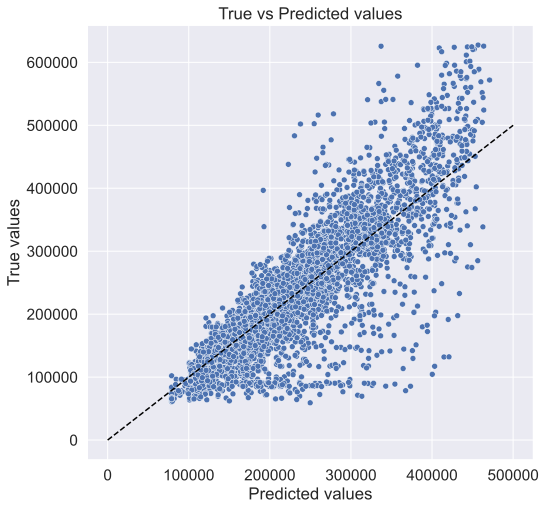

In [129]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=10, 
                                 min_samples_leaf=30, 
                                 random_state=42,
                                 n_estimators=100                                   )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.684


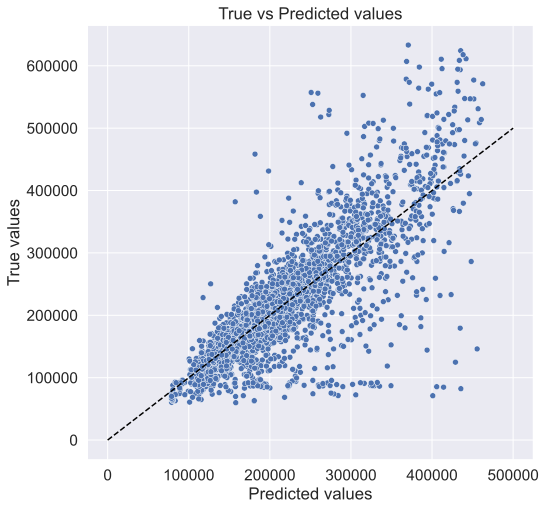

In [130]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

#### Перекрестная проверка

In [131]:
cv_score = cross_val_score(
    rf_model,
    X.fillna(-9999),
    y,
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
cv_score

array([0.68226778, 0.70042672, 0.6768677 , 0.72493959, 0.70067761])

In [132]:
cv_score.mean(), cv_score.std()

(0.6970358771000166, 0.01690106171993813)

In [133]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.6801348153800785, 0.7139369388199547)

#### Важность признаков

In [134]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
1              Square    0.554712
20       DistrictSize    0.323181
14           Social_3    0.023900
7           Ecology_1    0.020875
12           Social_1    0.012219
2          LifeSquare    0.011521
13           Social_2    0.010928
6           HouseYear    0.010185
3       KitchenSquare    0.008806
0               Rooms    0.005260
4               Floor    0.004855
5          HouseFloor    0.003692
16        Helthcare_2    0.003439
15       Healthcare_1    0.003137
17            Shops_1    0.003130
19         Shops_2__B    0.000059
18         Shops_2__A    0.000044
22  D_Mediumpopulated    0.000028
21   D_Underpopulated    0.000028
10       Ecology_3__A    0.000000
11       Ecology_3__B    0.000000
9        Ecology_2__B    0.000000
8        Ecology_2__A    0.000000
23    D_Overpopulated    0.000000

### Построение прогноза <a class='anchor' id='forecast'>

In [135]:
X_test_for_pred = test_df.loc[:,['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor','HouseYear',
                 'Ecology_1', 'Ecology_2__A', 'Ecology_2__B', 'Ecology_3__A', 'Ecology_3__B','Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2__A', 'Shops_2__B','DistrictSize', 'D_Underpopulated',
                'D_Mediumpopulated','D_Overpopulated']]
X_test_for_pred.head(10)


Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
0    2.0  49.882645   33.432781       6.000000    6.0        14.0       1972   
1    2.0  69.263184   59.189529      10.073655    1.0         1.0       1977   
2    1.0  40.177189   15.948246      12.000000    2.0         5.0       1909   
3    2.0  73.046608   51.940842       9.000000   22.0        22.0       2007   
4    1.0  47.527111   40.614758       6.912355   17.0        17.0       2017   
5    1.0  40.675625   34.759754       5.915874   21.0        21.0       1977   
6    2.0  68.099541   58.195126       9.904414    2.0        17.0       1977   
7    2.0  48.193897   32.857643       6.000000    5.0        14.0       1972   
8    3.0  72.277107   45.968758       9.000000   17.0        17.0       1997   
9    3.0  80.219398   47.660259       9.000000   13.0        17.0       2014   

   Ecology_1  Ecology_2__A  Ecology_2__B  ...  Social_3  Healthcare_1  \
0   0.310199           0.0           1.0  ...         1         900.0   
1   0.075779           0.0           1.0  ...         3         900.0   
2   0.000000           0.0           1.0  ...         2        4702.0   
3   0.101872           0.0           1.0  ...         3         900.0   
4   0.072158           0.0           1.0  ...         1         900.0   
5   0.049637           0.0           1.0  ...         0         229.0   
6   0.075779           0.0           1.0  ...         3         900.0   
7   0.135650           0.0           1.0  ...         6         350.0   
8   0.041116           0.0           1.0  ...         4         900.0   
9   0.243205           0.0           1.0  ...         0         540.0   

   Helthcare_2  Shops_1  Shops_2__A  Shops_2__B  DistrictSize  \
0            0        0         0.0         1.0            91   
1            0        2         0.0         1.0            61   
2            5        5         0.0         1.0             2   
3            3        3         0.0         1.0            49   
4            0        0         1.0         0.0           391   
5            1        3         0.0         1.0            91   
6            0        2         0.0         1.0           264   
7            3       11         0.0         1.0            21   
8            1        4         0.0         1.0            42   
9            0        0         0.0         1.0           257   

   D_Underpopulated  D_Mediumpopulated  D_Overpopulated  
0                 1                  0                0  
1                 1                  0                0  
2                 1                  0                0  
3                 1                  0                0  
4                 0                  0                1  
5                 1                  0                0  
6                 0                  0                1  
7                 1                  0                0  
8                 1                  0                0  
9                 0                  0                1  

[10 rows x 24 columns]

In [136]:
cols_for_scale = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                'Healthcare_1', 'Helthcare_2', 'Shops_1', 'DistrictSize']
X_test_for_pred.loc[:, cols_for_scale]

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
0       2.0  49.882645   33.432781       6.000000    6.0        14.0   
1       2.0  69.263184   59.189529      10.073655    1.0         1.0   
2       1.0  40.177189   15.948246      12.000000    2.0         5.0   
3       2.0  73.046608   51.940842       9.000000   22.0        22.0   
4       1.0  47.527111   40.614758       6.912355   17.0        17.0   
...     ...        ...         ...            ...    ...         ...   
4995    3.0  67.133911   50.809795       6.000000    5.0         9.0   
4996    1.0  40.198471   21.807060      10.000000   12.0        17.0   
4997    3.0  77.842178   48.282623       9.000000   22.0        22.0   
4998    2.0  81.305222   69.480171      11.825052    4.0        12.0   
4999    2.0  60.555695   51.748459       8.807236   10.0        17.0   

      HouseYear  Ecology_1  Social_1  Social_2  Social_3  Healthcare_1  \
0          1972   0.310199        11      2748         1         900.0   
1          1977   0.075779         6      1437         3         900.0   
2          1909   0.000000        30      7538         2        4702.0   
3          2007   0.101872        23      4583         3         900.0   
4          2017   0.072158         2       629         1         900.0   
...         ...        ...       ...       ...       ...           ...   
4995       1973   0.000170        36      5992         0         900.0   
4996       2017   0.007122         1       264         0         900.0   
4997       1989   0.090799        74     19083         2         900.0   
4998       1977   0.072158         2       629         1         900.0   
4999       1977   0.000078        22      6398         2        1046.0   

      Helthcare_2  Shops_1  DistrictSize  
0               0        0            91  
1               0        2            61  
2               5        5             2  
3               3        3            49  
4               0        0           391  
...           ...      ...           ...  
4995            1        1            45  
4996            0        1           344  
4997            5       15            36  
4998            0        0           122  
4999            3       23           115  

[5000 rows x 15 columns]

In [137]:
X_test_for_pred[cols_for_scale] = scaler.transform(X_test_for_pred[cols_for_scale])

In [138]:
y_test_preds = rf_model.predict(X_test_for_pred)
test_df['Price'] = y_test_preds
test_df.head(10)

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725         58    2.0  49.882645   33.432781       6.000000    6.0   
1  15856         74    2.0  69.263184   59.189529      10.073655    1.0   
2   5480        190    1.0  40.177189   15.948246      12.000000    2.0   
3  15664         47    2.0  73.046608   51.940842       9.000000   22.0   
4  14275         27    1.0  47.527111   40.614758       6.912355   17.0   
5   7633         53    1.0  40.675625   34.759754       5.915874   21.0   
6  13329         23    2.0  68.099541   58.195126       9.904414    2.0   
7   5502         32    2.0  48.193897   32.857643       6.000000    5.0   
8   4220         96    3.0  72.277107   45.968758       9.000000   17.0   
9  11538          6    3.0  80.219398   47.660259       9.000000   13.0   

   HouseFloor  HouseYear  Ecology_1  ... D_Mediumpopulated D_Overpopulated  \
0        14.0       1972   0.310199  ...                 0               0   
1         1.0       1977   0.075779  ...                 0               0   
2         5.0       1909   0.000000  ...                 0               0   
3        22.0       2007   0.101872  ...                 0               0   
4        17.0       2017   0.072158  ...                 0               1   
5        21.0       1977   0.049637  ...                 0               0   
6        17.0       1977   0.075779  ...                 0               1   
7        14.0       1972   0.135650  ...                 0               0   
8        17.0       1997   0.041116  ...                 0               0   
9        17.0       2014   0.243205  ...                 0               1   

   TypeofPopulation  Ecology_2__A  Ecology_2__B  Ecology_3__A  Ecology_3__B  \
0  D_Underpopulated           0.0           1.0           0.0           1.0   
1  D_Underpopulated           0.0           1.0           0.0           1.0   
2  D_Underpopulated           0.0           1.0           0.0           1.0   
3  D_Underpopulated           0.0           1.0           0.0           1.0   
4   D_Overpopulated           0.0           1.0           0.0           1.0   
5  D_Underpopulated           0.0           1.0           0.0           1.0   
6   D_Overpopulated           0.0           1.0           0.0           1.0   
7  D_Underpopulated           0.0           1.0           0.0           1.0   
8  D_Underpopulated           0.0           1.0           0.0           1.0   
9   D_Overpopulated           0.0           1.0           0.0           1.0   

   Shops_2__A Shops_2__B          Price  
0         0.0        1.0  197273.021560  
1         0.0        1.0  287284.336961  
2         0.0        1.0  232472.458884  
3         0.0        1.0  368565.733347  
4         1.0        0.0  138592.703388  
5         0.0        1.0  182818.887275  
6         0.0        1.0  187444.710672  
7         0.0        1.0  222245.523549  
8         0.0        1.0  358528.817021  
9         0.0        1.0  215488.107541  

[10 rows x 31 columns]

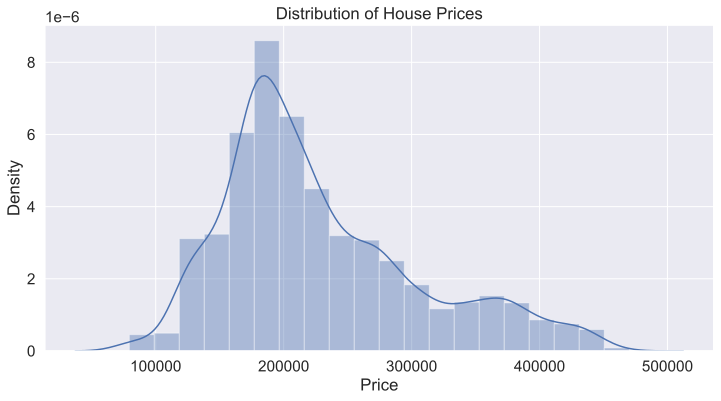

In [139]:
plt.figure(figsize = (12, 6))

sns.distplot(test_df['Price'], bins=20) 

y = np.linspace(0, 0.000005, 10)

plt.title('Distribution of House Prices')
plt.show()

In [140]:
test_df.drop(['DistrictSize', 'D_Underpopulated', 'D_Mediumpopulated', 'D_Overpopulated', 'TypeofPopulation', 
             'Ecology_2__A', 'Ecology_2__B', 'Ecology_3__A', 'Ecology_3__B', 'Shops_2__A', 'Shops_2__B'], axis=1, inplace=True)

In [141]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   category
 1   DistrictId     5000 non-null   category
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     5000 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   float32 
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int8    
 15  Healthcare_1   5000 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

### Сохранение результатов <a class='anchor' id='save'>

In [142]:
predictions_df_path = './EYakovleva_predictions.csv'
test_df.to_csv(predictions_df_path, index=False, encoding='utf-8')